In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
plt.style.use('ggplot')
pd.set_option('display.max_columns', None) # to display all columns of each printed dataframe

# Loading Data

The data on schools in England come from the UK government, specifically from the school performance comparison service:
https://bit.ly/2YKztfa

The current dataset includes only records for the latest available school year, 2018-2019, and only for *primary* schools (key stages 1 and 2, for children of age 5-11, though some schools in this dataset also have students of older age). 

In [2]:
%%time
df = pd.read_excel('england_ks2final.xlsx', na_values="SUPP")

Wall time: 57 s


The file is quite large and takes about a minute to load

In [3]:
df.memory_usage().sum() # bytes of memory consumed by the whole dataframe

41996480

Let's take a look at the dataframe dimensionality, feature names and types

In [4]:
df.shape

(16508, 318)

In [5]:
df.columns

Index(['RECTYPE', 'ALPHAIND', 'LEA', 'ESTAB', 'URN', 'SCHNAME', 'ADDRESS1',
       'ADDRESS2', 'ADDRESS3', 'TOWN',
       ...
       'MATPROG_UNADJUSTED', 'READPROG_DESCR_17', 'WRITPROG_DESCR_17',
       'MATPROG_DESCR_17', 'READPROG_DESCR_18', 'WRITPROG_DESCR_18',
       'MATPROG_DESCR_18', 'READPROG_DESCR', 'WRITPROG_DESCR',
       'MATPROG_DESCR'],
      dtype='object', length=318)

In [6]:
df.index # uses pandas default index, for now

RangeIndex(start=0, stop=16508, step=1)

In [7]:
df.index.is_unique

True

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16508 entries, 0 to 16507
Columns: 318 entries, RECTYPE to MATPROG_DESCR
dtypes: float64(200), int64(1), object(117)
memory usage: 40.1+ MB


# Data Cleaning and Preprocessing

## Feature Selection

The total number of features (columns) in the dataframe is quite large, at 318. Investigating all of these is unlikely to be feasible, and we can instead focus only on a subset of these, with the meanings as in the table below.

To a large extent, feature selection for the purpose of this project is a judgement call, since pretty much all of them contain useful information. Some of the reasons are quite straightforward: certian columns (like school phone number) are not relevant for this type of analysis, and many columns contain duplicated information and/or are unambiguously redundant (e.g. the *number* of pupils achieving high proficiency in mathematics vs the *percentage* of pupils achieving the same, or the percentages of *disadvantaged* pupils in the same category vs the percentage of *non-disadvantaged* pupils in the same category). Since the focus will be on school performance as a whole, features pertaining specifically to boys or girls will not be included either (moreover, proper accounting for them would be complicated by the fact that a significant proportion of schools in England are single-sex, and thus a girls-only school will have N/A for all features pertaining to boys). 

The decision was also made *not* to include any features containing raw *scores* in any subject or category, for now, and focus instead on *percentages*. One of the reasons for this is the intention to apply unsupervised learning methods to explore the data further, and some of these methods (e.g. K-Means clustering) require features to be on the same scale. While it is generally easy to rescale them (using, for example, sklearn.preprocessing.StandardScaler) doing so might introduce additional inaccuracy to data, and will be left aside, for now. Retained continuous features are all expected to have the same scale (percentage), but this will need to be checked later. 

Finally, several categorical features will be included, including, among others, religious denomination and school type. While some of these columns may contain similar information (specifically postcodes, town names, and parliamentary constituencies) they will be retained for now. They are relevant for analysis (it will be important to undestand, for example, whether schools with religious affiliation tend to perform better or worse than more 'secular' ones, and whether this difference, if any, is statistically significant). Since the main goal of the project is to identify locations with better schools, several approaches to 'slicing' the data (e.g. by towns and post districts) will be attempted later. 

|Field Name|Description|
|:--|:--|
|URN|School unique reference number|
|SCHNAME|School/Local authority name|
|TOWN|School town|
|PCODE|School postcode|
|PCON_NAME|School parliamentary constituency name|
|NFTYPE|School type. Rectype 1: AC = Academy Sponsor Led (NFTYPE 20), CY = Community school (21), VA = Voluntary Aided school (22), VC = Voluntary Controlled school (23), FD = Foundation school (24), CTC = City Technology College (25), ACC = Academy converter (51), F = Free school (52). Rectype 2: CYS = Community special (26), FDS = Foundation special (27), ACS = Academy special (50), FS = Free Special School (53), ACCS = Academy Converter Special (55)|
|RELDENOM|Religious denomination|
|AGERANGE|Age range|
|PTKS1GROUP_L|Percentage of pupils in cohort with low KS1 attainment|
|PTKS1GROUP_M|Percentage of pupils in cohort with medium KS1 attainment|
|PTKS1GROUP_H|Percentage of pupils in cohort with high KS1 attainment|
|PTNotFSM6CLA1A|Percentage of key stage 2 pupils who are not disadvantaged|
|PTRWM_EXP|Percentage of pupils reaching the expected standard in reading, writing and maths|
|PTRWM_HIGH|Percentage of pupils achieving a high score in reading and maths and working at greater depth in writing|
|PTREAD_EXP|Percentage of pupils reaching the expected standard in reading|
|PTREAD_HIGH|Percentage of pupils achieving a high score in reading|
|PTGPS_EXP|Percentage of pupils reaching the expected standard in grammar, punctuation and spelling|
|PTGPS_HIGH|Percentage of pupils achieving a high score in grammar, punctuation and spelling|
|PTMAT_EXP|Percentage of pupils reaching the expected standard in maths|
|PTMAT_HIGH|Percentage of pupils achieving a high score in maths|
|PTWRITTA_EXP|Percentage of pupils reaching the expected standard in writing|
|PTWRITTA_HIGH|Percentage of pupils working at greater depth within the expected standard in writing|
|PTSCITA_EXP|Percentage of pupils reaching the expected standard in science TA|
|PTEALGRP1|Percentage of eligible pupils with English as first language|
|PSENELE|Percentage of eligible pupils with EHC plan|
|PSENELK|Percentage of eligible pupils with SEN support|
|PTNOTFSM6CLA1A_18|Percentage of key stage 2 pupils who are not disadvantaged one year prior|
|PTRWM_EXP_18|Percentage of pupils reaching the expected standard in reading, writing and maths one year prior|
|PTRWM_HIGH_18|Percentage of pupils achieving a high score in reading and maths and working at greater depth in writing  one year prior|
|PTNOTFSM6CLA1A_17|Percentage of key stage 2 pupils who are not disadvantaged two years prior|
|PTRWM_EXP_17|Percentage of pupils reaching the expected standard in reading, writing and maths two years prior|
|PTRWM_HIGH_17|Percentage of pupils achieving a high score in reading and maths and working at greater depth in writing two years prior|
|PTRWM_EXP_3YR|Percentage of pupils reaching the expected standard in reading, writing and maths  - 3 year total|
|PTRWM_HIGH_3YR|Percentage of pupils achieving a high score in reading and maths and working at greater depth in writing  - 3 year total|


In [9]:
selected_columns = [
    "URN", "SCHNAME", "TOWN", "PCODE", "PCON_NAME", "NFTYPE", "RELDENOM", "AGERANGE", 
    "PTKS1GROUP_L", "PTKS1GROUP_M", "PTKS1GROUP_H", "PTNotFSM6CLA1A",
    "PTRWM_EXP", "PTRWM_HIGH", "PTREAD_EXP", "PTREAD_HIGH", "PTGPS_EXP", 
    "PTGPS_HIGH", "PTMAT_EXP", "PTMAT_HIGH", "PTWRITTA_EXP", "PTWRITTA_HIGH", 
    "PTSCITA_EXP", "PTEALGRP1", "PSENELE", "PSENELK", "PTNOTFSM6CLA1A_18", 
    "PTRWM_EXP_18", "PTRWM_HIGH_18", "PTNOTFSM6CLA1A_17", "PTRWM_EXP_17", 
    "PTRWM_HIGH_17", "PTRWM_EXP_3YR", "PTRWM_HIGH_3YR"
    ]
df = df[selected_columns]

In [10]:
df.shape

(16508, 34)

In [11]:
df.columns

Index(['URN', 'SCHNAME', 'TOWN', 'PCODE', 'PCON_NAME', 'NFTYPE', 'RELDENOM',
       'AGERANGE', 'PTKS1GROUP_L', 'PTKS1GROUP_M', 'PTKS1GROUP_H',
       'PTNotFSM6CLA1A', 'PTRWM_EXP', 'PTRWM_HIGH', 'PTREAD_EXP',
       'PTREAD_HIGH', 'PTGPS_EXP', 'PTGPS_HIGH', 'PTMAT_EXP', 'PTMAT_HIGH',
       'PTWRITTA_EXP', 'PTWRITTA_HIGH', 'PTSCITA_EXP', 'PTEALGRP1', 'PSENELE',
       'PSENELK', 'PTNOTFSM6CLA1A_18', 'PTRWM_EXP_18', 'PTRWM_HIGH_18',
       'PTNOTFSM6CLA1A_17', 'PTRWM_EXP_17', 'PTRWM_HIGH_17', 'PTRWM_EXP_3YR',
       'PTRWM_HIGH_3YR'],
      dtype='object')

In [12]:
df.memory_usage().sum()

4490304

## Duplicated or Missing Values

In [13]:
df.duplicated().values.any()

False

All records (rows) in the dataframe are unique

In [14]:
df.isnull().values.any()

True

However, some of these records contain missing values

In [15]:
df.describe()

,PTKS1GROUP_L,PTKS1GROUP_M,PTKS1GROUP_H,PTNotFSM6CLA1A,PTRWM_EXP,PTRWM_HIGH,PTREAD_EXP,PTREAD_HIGH,PTGPS_EXP,PTGPS_HIGH,PTMAT_EXP,PTMAT_HIGH,PTWRITTA_EXP,PTWRITTA_HIGH,PTSCITA_EXP,PTEALGRP1,PSENELE,PSENELK,PTNOTFSM6CLA1A_18,PTRWM_EXP_18,PTRWM_HIGH_18,PTNOTFSM6CLA1A_17,PTRWM_EXP_17,PTRWM_HIGH_17,PTRWM_EXP_3YR,PTRWM_HIGH_3YR
count,15633.000000,15633.000000,15633.000000,15633.000000,15632.000000,15632.000000,15633.000000,15633.000000,15632.000000,15632.000000,15632.000000,15632.000000,15633.000000,15633.000000,15633.000000,15633.000000,15633.000000,15633.000000,15242.000000,15240.000000,15240.000000,14863.000000,14862.000000,14862.000000,14606.000000,14083.000000
mean,0.107795,0.565103,0.327413,0.693196,0.634661,0.100817,0.722765,0.266740,0.761829,0.337836,0.766962,0.252448,0.766641,0.197276,0.814133,0.834308,0.057641,0.149640,0.692965,0.632410,0.096105,0.683169,0.603305,0.086108,0.645959,0.101475
std,0.167547,0.147198,0.144141,0.197305,0.193203,0.081609,0.188728,0.139234,0.192186,0.172047,0.195326,0.144658,0.184906,0.118463,0.186933,0.224414,0.186730,0.095381,0.199625,0.196303,0.080042,0.205310,0.195663,0.075479,0.135041,0.062035
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.010000,0.010000
25%,0.030000,0.500000,0.240000,0.560000,0.550000,0.040000,0.660000,0.170000,0.710000,0.220000,0.710000,0.150000,0.730000,0.120000,0.780000,0.780000,0.000000,0.080000,0.560000,0.550000,0.030000,0.540000,0.500000,0.030000,0.570000,0.060000
50%,0.070000,0.580000,0.330000,0.730000,0.670000,0.090000,0.760000,0.260000,0.800000,0.330000,0.810000,0.240000,0.800000,0.190000,0.850000,0.930000,0.010000,0.140000,0.730000,0.670000,0.080000,0.720000,0.630000,0.070000,0.650000,0.090000
75%,0.120000,0.650000,0.420000,0.850000,0.760000,0.140000,0.840000,0.350000,0.880000,0.450000,0.880000,0.340000,0.870000,0.270000,0.910000,1.000000,0.040000,0.200000,0.850000,0.760000,0.140000,0.850000,0.730000,0.130000,0.740000,0.130000
max,1.000000,1.000000,0.890000,1.000000,1.000000,0.710000,1.000000,0.940000,1.000000,1.000000,1.000000,1.000000,1.000000,0.880000,1.000000,1.000000,1.000000,0.830000,1.000000,1.000000,0.670000,1.000000,1.000000,0.810000,1.000000,0.560000


In [16]:
df.shape

(16508, 34)

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16508 entries, 0 to 16507
Data columns (total 34 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   URN                16508 non-null  object 
 1   SCHNAME            16508 non-null  object 
 2   TOWN               16507 non-null  object 
 3   PCODE              16508 non-null  object 
 4   PCON_NAME          16506 non-null  object 
 5   NFTYPE             16508 non-null  object 
 6   RELDENOM           16508 non-null  object 
 7   AGERANGE           16508 non-null  object 
 8   PTKS1GROUP_L       15633 non-null  float64
 9   PTKS1GROUP_M       15633 non-null  float64
 10  PTKS1GROUP_H       15633 non-null  float64
 11  PTNotFSM6CLA1A     15633 non-null  float64
 12  PTRWM_EXP          15632 non-null  float64
 13  PTRWM_HIGH         15632 non-null  float64
 14  PTREAD_EXP         15633 non-null  float64
 15  PTREAD_HIGH        15633 non-null  float64
 16  PTGPS_EXP          156

Now only 34 features are used, instead of previous 318. Memory usage also went down from more than 40 MB to around 4 MB.

Looking at data types, we can notice that continuous features are all of type float64 (consistent with the fact that they are all supposed to be expressed as percentages), while the categorical ones (e.g. the names of parliamentary constituencies) are of type object. The latter is expected too, since object is supposed to imply text or mixed numeric and non-numeric values. 

Also we can see that the number of non-null values is *not* the same across features. This may also suggest a problem with missing data, which has to be dealt with accordingly.

Let's take a look at first 10 and last 10 rows of the dataframe.

In [18]:
df.head(10)

,URN,SCHNAME,TOWN,PCODE,PCON_NAME,NFTYPE,RELDENOM,AGERANGE,PTKS1GROUP_L,PTKS1GROUP_M,PTKS1GROUP_H,PTNotFSM6CLA1A,PTRWM_EXP,PTRWM_HIGH,PTREAD_EXP,PTREAD_HIGH,PTGPS_EXP,PTGPS_HIGH,PTMAT_EXP,PTMAT_HIGH,PTWRITTA_EXP,PTWRITTA_HIGH,PTSCITA_EXP,PTEALGRP1,PSENELE,PSENELK,PTNOTFSM6CLA1A_18,PTRWM_EXP_18,PTRWM_HIGH_18,PTNOTFSM6CLA1A_17,PTRWM_EXP_17,PTRWM_HIGH_17,PTRWM_EXP_3YR,PTRWM_HIGH_3YR
0,141279,Bringhurst Primary School,Market Harborough,LE16 8RH,Rutland and Melton,ACC,Does not apply,4-11,0.00,0.50,0.50,0.85,0.96,0.27,0.96,0.54,0.96,0.62,1.00,0.54,1.00,0.46,1.00,1.00,0.00,0.12,0.92,0.68,0.20,0.88,0.88,0.13,0.84,0.20
1,119910,Buckminster Primary School,Grantham,NG33 5RZ,Rutland and Melton,CY,Does not apply,4-11,0.06,0.71,0.24,0.88,0.65,0.24,0.82,0.35,0.76,0.29,0.71,0.35,0.94,0.35,0.88,1.00,0.00,0.06,0.84,0.79,0.11,0.87,0.60,0.00,0.69,0.12
2,139342,Great Dalby School,Melton Mowbray,LE14 2HA,Rutland and Melton,ACC,Does not apply,5-11,0.00,0.57,0.43,0.86,0.86,0.14,0.95,0.38,0.90,0.48,0.95,0.33,0.86,0.38,1.00,1.00,0.00,0.24,0.90,0.80,0.20,0.90,0.80,0.25,0.82,0.20
3,119912,Burton-on-the-Wolds Primary School,Loughborough,LE12 5TB,Loughborough,CY,Does not apply,4-11,0.04,0.46,0.50,0.88,0.92,0.44,0.96,0.64,0.96,0.68,0.96,0.68,0.92,0.52,0.96,1.00,0.00,0.16,0.86,0.91,0.41,0.92,0.88,0.16,0.90,0.33
4,119913,Belvoirdale Community Primary School,Coalville,LE67 3RD,North West Leicestershire,CY,Does not apply,4-11,0.15,0.56,0.29,0.74,0.49,0.05,0.56,0.09,0.67,0.28,0.60,0.16,0.67,0.16,0.53,0.74,0.02,0.28,0.66,0.61,0.03,0.65,0.50,0.05,0.53,0.04
5,141222,Christ Church & Saint Peter's Cofe Primary School,Loughborough,LE12 7JU,Charnwood,AC,Church of England,5-11,0.13,0.55,0.31,0.82,0.69,0.18,0.73,0.25,0.87,0.39,0.84,0.28,0.90,0.27,0.88,1.00,0.03,0.37,0.73,0.68,0.13,0.67,0.63,0.09,0.67,0.14
6,119914,Ellistown Community Primary School,Coalville,LE67 1EN,North West Leicestershire,CY,Does not apply,4-11,0.00,0.58,0.42,0.90,0.65,0.19,0.74,0.32,0.90,0.39,0.81,0.32,0.94,0.23,0.90,0.97,0.00,0.00,0.82,0.71,0.18,0.87,0.84,0.16,0.73,0.18
7,119915,Hugglescote Community Primary School,Coalville,LE67 2HA,North West Leicestershire,CY,Does not apply,4-11,0.18,0.58,0.25,0.77,0.56,0.05,0.58,0.19,0.68,0.33,0.72,0.14,0.72,0.18,0.77,1.00,0.11,0.21,0.88,0.56,0.08,0.90,0.65,0.05,0.59,0.06
8,119916,Woodstone Community Primary School,Coalville,LE67 2AH,North West Leicestershire,CY,Does not apply,4-11,0.03,0.55,0.42,0.81,0.71,0.10,0.74,0.39,0.84,0.45,0.90,0.32,0.84,0.19,0.90,1.00,0.00,0.13,0.90,0.87,0.10,0.90,0.55,0.06,0.71,0.09
9,119917,New Swannington Primary School,Coalville,LE67 5DQ,North West Leicestershire,CY,Does not apply,4-11,0.04,0.58,0.38,0.93,0.59,0.19,0.70,0.30,0.63,0.37,0.74,0.30,0.81,0.22,0.81,1.00,0.04,0.22,0.88,0.88,0.17,1.00,0.81,0.08,0.75,0.14


In [19]:
df.tail(10)

,URN,SCHNAME,TOWN,PCODE,PCON_NAME,NFTYPE,RELDENOM,AGERANGE,PTKS1GROUP_L,PTKS1GROUP_M,PTKS1GROUP_H,PTNotFSM6CLA1A,PTRWM_EXP,PTRWM_HIGH,PTREAD_EXP,PTREAD_HIGH,PTGPS_EXP,PTGPS_HIGH,PTMAT_EXP,PTMAT_HIGH,PTWRITTA_EXP,PTWRITTA_HIGH,PTSCITA_EXP,PTEALGRP1,PSENELE,PSENELK,PTNOTFSM6CLA1A_18,PTRWM_EXP_18,PTRWM_HIGH_18,PTNOTFSM6CLA1A_17,PTRWM_EXP_17,PTRWM_HIGH_17,PTRWM_EXP_3YR,PTRWM_HIGH_3YR
16498,,Northamptonshire,,,,,,,0.09,0.57,0.34,0.76,0.61,0.09,0.70,0.24,0.75,0.32,0.75,0.23,0.77,0.18,0.81,0.83,0.03,0.13,0.75,0.61,0.08,0.74,0.57,0.07,0.60,0.08
16499,,Northumberland,,,,,,,0.07,0.60,0.33,0.71,0.66,0.11,0.75,0.27,0.76,0.31,0.79,0.26,0.80,0.24,0.85,0.98,0.04,0.13,0.71,0.65,0.10,0.70,0.61,0.09,0.64,0.10
16500,,Oxfordshire,,,,,,,0.08,0.56,0.36,0.80,0.65,0.11,0.74,0.29,0.77,0.33,0.79,0.24,0.78,0.22,0.84,0.85,0.03,0.17,0.80,0.63,0.10,0.78,0.61,0.09,0.63,0.10
16501,,Somerset,,,,,,,0.08,0.56,0.35,0.75,0.61,0.09,0.71,0.25,0.73,0.29,0.75,0.22,0.77,0.21,0.82,0.93,0.02,0.15,0.77,0.62,0.08,0.75,0.59,0.08,0.61,0.09
16502,,Suffolk,,,,,,,0.09,0.57,0.34,0.72,0.62,0.09,0.71,0.24,0.73,0.29,0.77,0.22,0.77,0.18,0.80,0.92,0.03,0.12,0.73,0.61,0.09,0.72,0.57,0.08,0.60,0.08
16503,,Surrey,,,,,,,0.06,0.49,0.45,0.83,0.70,0.14,0.79,0.35,0.82,0.42,0.83,0.33,0.81,0.23,0.85,0.86,0.04,0.13,0.83,0.70,0.13,0.82,0.67,0.13,0.69,0.13
16504,,Warwickshire,,,,,,,0.07,0.56,0.36,0.77,0.66,0.11,0.75,0.29,0.79,0.37,0.78,0.27,0.80,0.22,0.85,0.89,0.03,0.14,0.78,0.67,0.11,0.77,0.62,0.10,0.65,0.11
16505,,West Sussex,,,,,,,0.08,0.62,0.29,0.81,0.63,0.07,0.74,0.27,0.75,0.31,0.77,0.23,0.76,0.13,0.83,0.89,0.03,0.16,0.80,0.62,0.07,0.80,0.55,0.05,0.60,0.06
16506,,,,,,,,,0.09,0.57,0.34,0.69,0.65,0.11,0.73,0.27,0.78,0.36,0.79,0.27,0.78,0.20,0.83,0.78,0.03,0.15,0.69,0.64,0.10,0.69,0.61,0.09,0.63,0.10
16507,,,,,,,,,0.09,0.57,0.34,0.69,0.65,0.11,0.73,0.27,0.78,0.36,0.79,0.27,0.78,0.20,0.83,0.79,0.03,0.15,0.69,0.64,0.10,0.68,0.61,0.09,0.63,0.10


We can see an inconsistency here. While most *records* (or rows) in the dataframe refer to individual schools, the bottom ones appear to be aggregates by boroughs or counties, as well as totals. 

Let's move the records which do *not* have URN (unique reference number) and hence do *not* correspond to individual schools, into a separate dataframe. 

Inconveniently, the missing URNs are not always blank (these are usually automatically recognised as N/A), but are more often specified as empty stings with whitespace (e.g. " "). This can also explain why we had '16508 non-null  object' for URN (if all missing ones were properly coded as N/A, there would have been less). 

In [20]:
# df[df['URN'].isna()]
df = df.dropna(subset=['SCHNAME'])
df = df[df['SCHNAME'] != " "] # removing the last row with empty school name
df_bor = df[(df['URN'].str.contains(' ') == True) | (df['URN'].isna())]
df_bor['URN'] = np.nan # populating all school URNs for boroughs with N/A for consistency

<ipython-input-20-a584eb31ce77>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_bor['URN'] = np.nan # populating all school URNs for boroughs with N/A for consistency


In [21]:
df = df[df['URN'].notna()]
df = df[~(df['URN'].str.contains(' ') == True)] # df should now contain only individual schools

In [22]:
df_bor.head(10)

,URN,SCHNAME,TOWN,PCODE,PCON_NAME,NFTYPE,RELDENOM,AGERANGE,PTKS1GROUP_L,PTKS1GROUP_M,PTKS1GROUP_H,PTNotFSM6CLA1A,PTRWM_EXP,PTRWM_HIGH,PTREAD_EXP,PTREAD_HIGH,PTGPS_EXP,PTGPS_HIGH,PTMAT_EXP,PTMAT_HIGH,PTWRITTA_EXP,PTWRITTA_HIGH,PTSCITA_EXP,PTEALGRP1,PSENELE,PSENELK,PTNOTFSM6CLA1A_18,PTRWM_EXP_18,PTRWM_HIGH_18,PTNOTFSM6CLA1A_17,PTRWM_EXP_17,PTRWM_HIGH_17,PTRWM_EXP_3YR,PTRWM_HIGH_3YR
16355,NaN,City of London,,,,,,,0.07,0.52,0.41,0.71,0.82,0.29,0.89,0.50,1.00,0.71,0.96,0.54,0.86,0.39,0.75,0.39,0.00,0.32,0.59,0.72,0.21,0.65,0.88,0.15,0.81,0.22
16356,NaN,Camden,,,,,,,0.10,0.61,0.29,0.50,0.73,0.16,0.80,0.34,0.84,0.46,0.86,0.34,0.82,0.27,0.86,0.40,0.05,0.17,0.48,0.72,0.14,0.47,0.67,0.12,0.71,0.14
16357,NaN,Greenwich,,,,,,,0.07,0.50,0.43,0.60,0.73,0.15,0.79,0.32,0.83,0.46,0.85,0.36,0.83,0.28,0.85,0.58,0.04,0.17,0.56,0.69,0.13,0.56,0.71,0.13,0.71,0.14
16358,NaN,Hackney,,,,,,,0.08,0.58,0.35,0.48,0.66,0.13,0.72,0.27,0.78,0.36,0.78,0.25,0.84,0.27,0.86,0.47,0.04,0.18,0.49,0.71,0.13,0.46,0.72,0.13,0.69,0.13
16359,NaN,Hammersmith and Fulham,,,,,,,0.08,0.56,0.36,0.56,0.73,0.14,0.79,0.36,0.84,0.51,0.83,0.35,0.84,0.26,0.87,0.50,0.04,0.16,0.54,0.74,0.16,0.50,0.74,0.14,0.74,0.15
16360,NaN,Islington,,,,,,,0.12,0.60,0.29,0.42,0.70,0.15,0.76,0.30,0.81,0.39,0.80,0.29,0.82,0.28,0.86,0.56,0.05,0.17,0.40,0.69,0.16,0.36,0.66,0.14,0.68,0.15
16361,NaN,Kensington and Chelsea,,,,,,,0.07,0.54,0.39,0.56,0.77,0.21,0.84,0.43,0.88,0.56,0.87,0.41,0.85,0.33,0.88,0.49,0.05,0.14,0.54,0.76,0.21,0.52,0.76,0.18,0.76,0.20
16362,NaN,Lambeth,,,,,,,0.09,0.62,0.29,0.50,0.71,0.13,0.79,0.30,0.83,0.44,0.84,0.31,0.81,0.24,0.85,0.48,0.06,0.17,0.51,0.70,0.12,0.49,0.68,0.11,0.70,0.12
16363,NaN,Lewisham,,,,,,,0.08,0.52,0.40,0.59,0.68,0.10,0.76,0.29,0.80,0.40,0.81,0.30,0.78,0.16,0.82,0.65,0.05,0.17,0.57,0.68,0.11,0.57,0.62,0.09,0.66,0.10
16364,NaN,Southwark,,,,,,,0.10,0.61,0.29,0.57,0.68,0.12,0.76,0.28,0.82,0.41,0.81,0.29,0.81,0.23,0.85,0.52,0.04,0.19,0.51,0.69,0.12,0.43,0.64,0.09,0.67,0.11


In [23]:
df_bor.tail(10)

,URN,SCHNAME,TOWN,PCODE,PCON_NAME,NFTYPE,RELDENOM,AGERANGE,PTKS1GROUP_L,PTKS1GROUP_M,PTKS1GROUP_H,PTNotFSM6CLA1A,PTRWM_EXP,PTRWM_HIGH,PTREAD_EXP,PTREAD_HIGH,PTGPS_EXP,PTGPS_HIGH,PTMAT_EXP,PTMAT_HIGH,PTWRITTA_EXP,PTWRITTA_HIGH,PTSCITA_EXP,PTEALGRP1,PSENELE,PSENELK,PTNOTFSM6CLA1A_18,PTRWM_EXP_18,PTRWM_HIGH_18,PTNOTFSM6CLA1A_17,PTRWM_EXP_17,PTRWM_HIGH_17,PTRWM_EXP_3YR,PTRWM_HIGH_3YR
16496,NaN,Lincolnshire,,,,,,,0.10,0.58,0.32,0.70,0.61,0.09,0.69,0.23,0.75,0.30,0.75,0.22,0.77,0.18,0.81,0.89,0.04,0.17,0.72,0.60,0.08,0.72,0.57,0.07,0.59,0.08
16497,NaN,Norfolk,,,,,,,0.09,0.58,0.34,0.72,0.60,0.07,0.70,0.23,0.71,0.26,0.75,0.21,0.75,0.16,0.82,0.89,0.03,0.15,0.72,0.59,0.07,0.70,0.57,0.07,0.59,0.07
16498,NaN,Northamptonshire,,,,,,,0.09,0.57,0.34,0.76,0.61,0.09,0.70,0.24,0.75,0.32,0.75,0.23,0.77,0.18,0.81,0.83,0.03,0.13,0.75,0.61,0.08,0.74,0.57,0.07,0.60,0.08
16499,NaN,Northumberland,,,,,,,0.07,0.60,0.33,0.71,0.66,0.11,0.75,0.27,0.76,0.31,0.79,0.26,0.80,0.24,0.85,0.98,0.04,0.13,0.71,0.65,0.10,0.70,0.61,0.09,0.64,0.10
16500,NaN,Oxfordshire,,,,,,,0.08,0.56,0.36,0.80,0.65,0.11,0.74,0.29,0.77,0.33,0.79,0.24,0.78,0.22,0.84,0.85,0.03,0.17,0.80,0.63,0.10,0.78,0.61,0.09,0.63,0.10
16501,NaN,Somerset,,,,,,,0.08,0.56,0.35,0.75,0.61,0.09,0.71,0.25,0.73,0.29,0.75,0.22,0.77,0.21,0.82,0.93,0.02,0.15,0.77,0.62,0.08,0.75,0.59,0.08,0.61,0.09
16502,NaN,Suffolk,,,,,,,0.09,0.57,0.34,0.72,0.62,0.09,0.71,0.24,0.73,0.29,0.77,0.22,0.77,0.18,0.80,0.92,0.03,0.12,0.73,0.61,0.09,0.72,0.57,0.08,0.60,0.08
16503,NaN,Surrey,,,,,,,0.06,0.49,0.45,0.83,0.70,0.14,0.79,0.35,0.82,0.42,0.83,0.33,0.81,0.23,0.85,0.86,0.04,0.13,0.83,0.70,0.13,0.82,0.67,0.13,0.69,0.13
16504,NaN,Warwickshire,,,,,,,0.07,0.56,0.36,0.77,0.66,0.11,0.75,0.29,0.79,0.37,0.78,0.27,0.80,0.22,0.85,0.89,0.03,0.14,0.78,0.67,0.11,0.77,0.62,0.10,0.65,0.11
16505,NaN,West Sussex,,,,,,,0.08,0.62,0.29,0.81,0.63,0.07,0.74,0.27,0.75,0.31,0.77,0.23,0.76,0.13,0.83,0.89,0.03,0.16,0.80,0.62,0.07,0.80,0.55,0.05,0.60,0.06


In [24]:
df.head(10)

,URN,SCHNAME,TOWN,PCODE,PCON_NAME,NFTYPE,RELDENOM,AGERANGE,PTKS1GROUP_L,PTKS1GROUP_M,PTKS1GROUP_H,PTNotFSM6CLA1A,PTRWM_EXP,PTRWM_HIGH,PTREAD_EXP,PTREAD_HIGH,PTGPS_EXP,PTGPS_HIGH,PTMAT_EXP,PTMAT_HIGH,PTWRITTA_EXP,PTWRITTA_HIGH,PTSCITA_EXP,PTEALGRP1,PSENELE,PSENELK,PTNOTFSM6CLA1A_18,PTRWM_EXP_18,PTRWM_HIGH_18,PTNOTFSM6CLA1A_17,PTRWM_EXP_17,PTRWM_HIGH_17,PTRWM_EXP_3YR,PTRWM_HIGH_3YR
0,141279,Bringhurst Primary School,Market Harborough,LE16 8RH,Rutland and Melton,ACC,Does not apply,4-11,0.00,0.50,0.50,0.85,0.96,0.27,0.96,0.54,0.96,0.62,1.00,0.54,1.00,0.46,1.00,1.00,0.00,0.12,0.92,0.68,0.20,0.88,0.88,0.13,0.84,0.20
1,119910,Buckminster Primary School,Grantham,NG33 5RZ,Rutland and Melton,CY,Does not apply,4-11,0.06,0.71,0.24,0.88,0.65,0.24,0.82,0.35,0.76,0.29,0.71,0.35,0.94,0.35,0.88,1.00,0.00,0.06,0.84,0.79,0.11,0.87,0.60,0.00,0.69,0.12
2,139342,Great Dalby School,Melton Mowbray,LE14 2HA,Rutland and Melton,ACC,Does not apply,5-11,0.00,0.57,0.43,0.86,0.86,0.14,0.95,0.38,0.90,0.48,0.95,0.33,0.86,0.38,1.00,1.00,0.00,0.24,0.90,0.80,0.20,0.90,0.80,0.25,0.82,0.20
3,119912,Burton-on-the-Wolds Primary School,Loughborough,LE12 5TB,Loughborough,CY,Does not apply,4-11,0.04,0.46,0.50,0.88,0.92,0.44,0.96,0.64,0.96,0.68,0.96,0.68,0.92,0.52,0.96,1.00,0.00,0.16,0.86,0.91,0.41,0.92,0.88,0.16,0.90,0.33
4,119913,Belvoirdale Community Primary School,Coalville,LE67 3RD,North West Leicestershire,CY,Does not apply,4-11,0.15,0.56,0.29,0.74,0.49,0.05,0.56,0.09,0.67,0.28,0.60,0.16,0.67,0.16,0.53,0.74,0.02,0.28,0.66,0.61,0.03,0.65,0.50,0.05,0.53,0.04
5,141222,Christ Church & Saint Peter's Cofe Primary School,Loughborough,LE12 7JU,Charnwood,AC,Church of England,5-11,0.13,0.55,0.31,0.82,0.69,0.18,0.73,0.25,0.87,0.39,0.84,0.28,0.90,0.27,0.88,1.00,0.03,0.37,0.73,0.68,0.13,0.67,0.63,0.09,0.67,0.14
6,119914,Ellistown Community Primary School,Coalville,LE67 1EN,North West Leicestershire,CY,Does not apply,4-11,0.00,0.58,0.42,0.90,0.65,0.19,0.74,0.32,0.90,0.39,0.81,0.32,0.94,0.23,0.90,0.97,0.00,0.00,0.82,0.71,0.18,0.87,0.84,0.16,0.73,0.18
7,119915,Hugglescote Community Primary School,Coalville,LE67 2HA,North West Leicestershire,CY,Does not apply,4-11,0.18,0.58,0.25,0.77,0.56,0.05,0.58,0.19,0.68,0.33,0.72,0.14,0.72,0.18,0.77,1.00,0.11,0.21,0.88,0.56,0.08,0.90,0.65,0.05,0.59,0.06
8,119916,Woodstone Community Primary School,Coalville,LE67 2AH,North West Leicestershire,CY,Does not apply,4-11,0.03,0.55,0.42,0.81,0.71,0.10,0.74,0.39,0.84,0.45,0.90,0.32,0.84,0.19,0.90,1.00,0.00,0.13,0.90,0.87,0.10,0.90,0.55,0.06,0.71,0.09
9,119917,New Swannington Primary School,Coalville,LE67 5DQ,North West Leicestershire,CY,Does not apply,4-11,0.04,0.58,0.38,0.93,0.59,0.19,0.70,0.30,0.63,0.37,0.74,0.30,0.81,0.22,0.81,1.00,0.04,0.22,0.88,0.88,0.17,1.00,0.81,0.08,0.75,0.14


In [25]:
df.tail(10)

,URN,SCHNAME,TOWN,PCODE,PCON_NAME,NFTYPE,RELDENOM,AGERANGE,PTKS1GROUP_L,PTKS1GROUP_M,PTKS1GROUP_H,PTNotFSM6CLA1A,PTRWM_EXP,PTRWM_HIGH,PTREAD_EXP,PTREAD_HIGH,PTGPS_EXP,PTGPS_HIGH,PTMAT_EXP,PTMAT_HIGH,PTWRITTA_EXP,PTWRITTA_HIGH,PTSCITA_EXP,PTEALGRP1,PSENELE,PSENELK,PTNOTFSM6CLA1A_18,PTRWM_EXP_18,PTRWM_HIGH_18,PTNOTFSM6CLA1A_17,PTRWM_EXP_17,PTRWM_HIGH_17,PTRWM_EXP_3YR,PTRWM_HIGH_3YR
16345,126155,St Anthony's School,Chichester,PO19 5PA,Chichester,CYS,Does not apply,4-16,1.00,0.00,0.00,0.47,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.93,1.00,0.00,0.50,0.0,0.0,0.67,0.0,0.0,NaN,NaN
16346,126156,"Littlegreen School, Compton",Chichester,PO18 9NW,Chichester,CYS,Does not apply,7-16,0.29,0.71,0.00,0.14,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.0,1.00,1.00,0.00,0.42,0.0,0.0,0.36,0.0,0.0,NaN,NaN
16347,126159,Palatine Primary School,Worthing,BN12 6JP,Worthing West,CYS,Does not apply,4-11,1.00,0.00,0.00,0.48,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.95,1.00,0.00,0.44,0.0,0.0,0.59,0.0,0.0,NaN,NaN
16348,126160,"Queen Elizabeth II Silver Jubilee School, Horsham",Horsham,RH13 5NW,Horsham,CYS,Does not apply,2-19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.50,0.0,0.0,NaN,NaN
16349,126162,Manor Green Primary School,Crawley,RH11 0DU,Crawley,CYS,Does not apply,2-11,0.93,0.07,0.00,0.69,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.79,1.00,0.00,0.61,0.0,0.0,0.65,0.0,0.0,NaN,NaN
16350,126163,"Fordwater School, Chichester",Chichester,PO19 6PP,Chichester,CYS,Does not apply,2-19,1.00,0.00,0.00,0.45,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.73,1.00,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16351,136114,Woodlands Meed,Burgess Hill,RH15 9EY,Mid Sussex,FDS,Does not apply,2-19,0.65,0.30,0.05,0.62,0.0,0.0,0.00,0.0,0.00,0.0,0.1,0.05,0.0,0.0,0.0,0.81,0.95,0.05,0.65,0.0,0.0,0.53,0.0,0.0,NaN,NaN
16352,145394,Brantridge School,Haywards Heath,RH17 6EQ,Mid Sussex,ACCS,Does not apply,6-13,0.40,0.60,0.00,0.50,0.0,0.0,0.25,0.0,0.13,0.0,0.0,0.00,0.0,0.0,0.0,1.00,1.00,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16353,126169,Herons Dale School,Shoreham-by-Sea,BN43 6TN,East Worthing and Shoreham,CYS,Does not apply,4-11,1.00,0.00,0.00,0.53,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.95,1.00,0.00,0.38,0.0,0.0,0.58,0.0,0.0,NaN,NaN
16354,126170,"Cornfield School, Littlehampton",Littlehampton,BN17 6HY,Bognor Regis and Littlehampton,CYS,Does not apply,9-16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [26]:
df['URN'].isna().any()

False

No N/A in the main dataframe, for unique reference numbers

In [27]:
df_bor['URN'].isna().all()

True

The dataframe for *boroughs* contains N/A for school URNs, as intended

In [28]:
df.shape

(16355, 34)

We can see there are 16355 Englsih schools altogether in the schools dataframe

In [29]:
df.describe()

,PTKS1GROUP_L,PTKS1GROUP_M,PTKS1GROUP_H,PTNotFSM6CLA1A,PTRWM_EXP,PTRWM_HIGH,PTREAD_EXP,PTREAD_HIGH,PTGPS_EXP,PTGPS_HIGH,PTMAT_EXP,PTMAT_HIGH,PTWRITTA_EXP,PTWRITTA_HIGH,PTSCITA_EXP,PTEALGRP1,PSENELE,PSENELK,PTNOTFSM6CLA1A_18,PTRWM_EXP_18,PTRWM_HIGH_18,PTNOTFSM6CLA1A_17,PTRWM_EXP_17,PTRWM_HIGH_17,PTRWM_EXP_3YR,PTRWM_HIGH_3YR
count,15480.000000,15480.000000,15480.000000,15480.000000,15479.000000,15479.000000,15480.000000,15480.000000,15479.000000,15479.000000,15479.000000,15479.000000,15480.000000,15480.000000,15480.000000,15480.000000,15480.000000,15480.000000,15091.000000,15089.000000,15089.000000,14712.000000,14711.000000,14711.000000,14455.000000,13932.000000
mean,0.107987,0.565017,0.327312,0.693340,0.634419,0.100734,0.722557,0.266632,0.761545,0.337526,0.766672,0.252222,0.766386,0.197198,0.813923,0.834911,0.057862,0.149630,0.693144,0.632197,0.096043,0.683345,0.603117,0.086075,0.645966,0.101484
std,0.168352,0.147885,0.144776,0.198043,0.194084,0.081943,0.189606,0.139836,0.193057,0.172724,0.196219,0.145244,0.185772,0.118969,0.187821,0.224614,0.187635,0.095816,0.200373,0.197215,0.080385,0.206087,0.196570,0.075822,0.135657,0.062298
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.010000,0.010000
25%,0.030000,0.500000,0.240000,0.560000,0.550000,0.040000,0.650000,0.170000,0.700000,0.220000,0.710000,0.150000,0.730000,0.110000,0.780000,0.780000,0.000000,0.080000,0.560000,0.550000,0.030000,0.540000,0.500000,0.030000,0.560000,0.060000
50%,0.070000,0.580000,0.330000,0.730000,0.670000,0.090000,0.760000,0.260000,0.800000,0.330000,0.810000,0.240000,0.800000,0.190000,0.850000,0.930000,0.010000,0.140000,0.730000,0.670000,0.080000,0.730000,0.630000,0.070000,0.650000,0.090000
75%,0.120000,0.650000,0.420000,0.850000,0.760000,0.150000,0.840000,0.350000,0.880000,0.450000,0.890000,0.340000,0.870000,0.270000,0.910000,1.000000,0.040000,0.200000,0.850000,0.760000,0.140000,0.850000,0.730000,0.130000,0.740000,0.130000
max,1.000000,1.000000,0.890000,1.000000,1.000000,0.710000,1.000000,0.940000,1.000000,1.000000,1.000000,1.000000,1.000000,0.880000,1.000000,1.000000,1.000000,0.830000,1.000000,1.000000,0.670000,1.000000,1.000000,0.810000,1.000000,0.560000


We can see that the scale of each continuous feature is indeed from 0 to 1, as expected (since they all are percentages), so we do not have obvious errors or outliers in the data, at least from first glance. But this will need to be checked further. 

Note that the number of columns in the table above is 26. The describe method of the pandas.DataFrame class includes, by default, only numeric and object features. The total number of features in the dataframe is 34. This is expected, since the first 7 features are distinctly categorical (e.g. religious denomination). 

Nevertheless, the fact that descriptive statistics were calculated for all features where we expected them does *not* mean on its own that everything is fine with these columns. Specifically we will need to check for N/A values, which are generally ignored in calculations. 

In [30]:
df.index # still the default pandas index

Int64Index([    0,     1,     2,     3,     4,     5,     6,     7,     8,
                9,
            ...
            16345, 16346, 16347, 16348, 16349, 16350, 16351, 16352, 16353,
            16354],
           dtype='int64', length=16355)

It will be more convenient if we change the default index to one of the columns, specifically to URN (only in the dataframe containing only school records, each with its own unique reference number)

In [31]:
df.set_index('URN', inplace=True)
df.index

Int64Index([141279, 119910, 139342, 119912, 119913, 141222, 119914, 119915,
            119916, 119917,
            ...
            126155, 126156, 126159, 126160, 126162, 126163, 136114, 145394,
            126169, 126170],
           dtype='int64', name='URN', length=16355)

In [32]:
df.index.is_unique

True

This worked fine. Our index is of type Int64Index, which, as the name suggests, allows only for integers, implying that the issue we had with missing values represented as spaces or empty strings has been resolved. Now every index is a series of URNs, each is recognised as integer as expected, and every single value in the index series is unique. 

Let's explore these missing values in more detail. 

In [33]:
len(df[df.isna().any(axis=1)]) / len(df)

0.16789972485478447

Almost 17% of all rows contain at least one N/A in at least one of their 33 columns. 
We may want to impute them later, but first need to understand why exactly they are missing. 

Imputation is generally complicated, and in many cases it is actually not needed, particularly for cases where data are missing *not* at random

In [34]:
df.shape

(16355, 33)

In [35]:
df.count().sort_values(ascending=False)

SCHNAME              16355
PCODE                16355
NFTYPE               16355
RELDENOM             16355
AGERANGE             16355
TOWN                 16354
PCON_NAME            16353
PTWRITTA_EXP         15480
PTREAD_HIGH          15480
PTNotFSM6CLA1A       15480
PTKS1GROUP_H         15480
PTKS1GROUP_M         15480
PTKS1GROUP_L         15480
PTEALGRP1            15480
PTWRITTA_HIGH        15480
PTSCITA_EXP          15480
PSENELE              15480
PSENELK              15480
PTREAD_EXP           15480
PTRWM_EXP            15479
PTGPS_HIGH           15479
PTRWM_HIGH           15479
PTGPS_EXP            15479
PTMAT_EXP            15479
PTMAT_HIGH           15479
PTNOTFSM6CLA1A_18    15091
PTRWM_EXP_18         15089
PTRWM_HIGH_18        15089
PTNOTFSM6CLA1A_17    14712
PTRWM_EXP_17         14711
PTRWM_HIGH_17        14711
PTRWM_EXP_3YR        14455
PTRWM_HIGH_3YR       13932
dtype: int64

Let's start with easier ones and figure out why one school has no TOWN and two schools have no PCON_NAME (parliamentary constituency). 

In [36]:
df[df['TOWN'].isnull()]

,SCHNAME,TOWN,PCODE,PCON_NAME,NFTYPE,RELDENOM,AGERANGE,PTKS1GROUP_L,PTKS1GROUP_M,PTKS1GROUP_H,PTNotFSM6CLA1A,PTRWM_EXP,PTRWM_HIGH,PTREAD_EXP,PTREAD_HIGH,PTGPS_EXP,PTGPS_HIGH,PTMAT_EXP,PTMAT_HIGH,PTWRITTA_EXP,PTWRITTA_HIGH,PTSCITA_EXP,PTEALGRP1,PSENELE,PSENELK,PTNOTFSM6CLA1A_18,PTRWM_EXP_18,PTRWM_HIGH_18,PTNOTFSM6CLA1A_17,PTRWM_EXP_17,PTRWM_HIGH_17,PTRWM_EXP_3YR,PTRWM_HIGH_3YR
URN,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
141807,Rye Community Primary School,NaN,TN31 7ND,Hastings and Rye,ACC,Does not apply,2-11,0.11,0.65,0.24,0.48,0.4,0.04,0.58,0.21,0.5,0.0,0.56,0.08,0.75,0.13,0.65,0.98,0.04,0.15,0.49,0.44,0.02,0.55,0.47,0.04,0.44,0.03


Looks like just a genuine omission for no good reason. This one is easy to fix, but we need to know what to replace it with (should it be Rye, Rye Harbour, RYE or something else?).

Let's check some other schools with similar postcodes.

In [37]:
df[(df['PCODE'].str.contains('TN31')) & (df['PCON_NAME']=='Hastings and Rye')]

,SCHNAME,TOWN,PCODE,PCON_NAME,NFTYPE,RELDENOM,AGERANGE,PTKS1GROUP_L,PTKS1GROUP_M,PTKS1GROUP_H,PTNotFSM6CLA1A,PTRWM_EXP,PTRWM_HIGH,PTREAD_EXP,PTREAD_HIGH,PTGPS_EXP,PTGPS_HIGH,PTMAT_EXP,PTMAT_HIGH,PTWRITTA_EXP,PTWRITTA_HIGH,PTSCITA_EXP,PTEALGRP1,PSENELE,PSENELK,PTNOTFSM6CLA1A_18,PTRWM_EXP_18,PTRWM_HIGH_18,PTNOTFSM6CLA1A_17,PTRWM_EXP_17,PTRWM_HIGH_17,PTRWM_EXP_3YR,PTRWM_HIGH_3YR
URN,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
146826,Rye Community Primary School,Rye,TN31 7ND,Hastings and Rye,ACC,None,2-11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
114389,Brede Primary School,Rye,TN31 6DG,Hastings and Rye,CY,Does not apply,4-11,0.31,0.23,0.46,0.44,0.75,0.13,0.81,0.38,0.75,0.56,0.75,0.44,0.75,0.25,0.81,1.00,0.06,0.19,0.60,0.80,0.10,0.64,0.57,0.07,0.70,0.10
114520,St Michael's Church of England Primary School,Playden Rye,TN31 7PJ,Hastings and Rye,VC,Church of England,5-11,0.07,0.64,0.29,0.80,0.33,0.00,0.53,0.13,0.40,0.07,0.53,0.13,0.73,0.00,0.80,0.93,0.07,0.20,0.79,0.47,0.05,1.00,0.88,0.25,0.50,0.07
141807,Rye Community Primary School,NaN,TN31 7ND,Hastings and Rye,ACC,Does not apply,2-11,0.11,0.65,0.24,0.48,0.40,0.04,0.58,0.21,0.50,0.00,0.56,0.08,0.75,0.13,0.65,0.98,0.04,0.15,0.49,0.44,0.02,0.55,0.47,0.04,0.44,0.03


This is strange. Turns out there are *two* schools not only in the exact same postcode, but sharing the same name: both are called Rye Community Primary School. Could it be the case that this is actually an error and the same school was included twice? This is entirely possible. However, we can see that URNs are actually different, suggesting these may be two different legal entities altogether.

Turns out that is indeed the case: one school was replaced by another, and URN 146826 actually refers to the new legal entity, which was established in 2018: https://get-information-schools.service.gov.uk/Establishments/Establishment/Details/141807#school-links

This should also explain why so many features are missing for this school. 

Should we delete one of these entities or keep both? Since they refer to the same school, in effect, it makes sense to leave only one. Which one to choose? In this case, it may be more helpful to keep the 'old' one, even if it technically no longer exist, since it has more historical data available. Since the aim of this project is not to select only one school but rather to select a good area, keeping a few defunct entities might be justified. It may be the case that the data available for that nonexisting school will help us learn more about the eare of Hastings and Rye. 

Let's update the TOWN column and delete the first row.

In [38]:
df.at[141807, 'TOWN'] = 'Rye'

In [39]:
df.drop(index=146826, inplace=True)

In [40]:
df.at[141807, 'TOWN']

'Rye'

In [41]:
df[(df['PCODE'].str.contains('TN31')) & (df['PCON_NAME']=='Hastings and Rye')] # no longer any N/A under TOWN, and now only three rows instead of four as before

,SCHNAME,TOWN,PCODE,PCON_NAME,NFTYPE,RELDENOM,AGERANGE,PTKS1GROUP_L,PTKS1GROUP_M,PTKS1GROUP_H,PTNotFSM6CLA1A,PTRWM_EXP,PTRWM_HIGH,PTREAD_EXP,PTREAD_HIGH,PTGPS_EXP,PTGPS_HIGH,PTMAT_EXP,PTMAT_HIGH,PTWRITTA_EXP,PTWRITTA_HIGH,PTSCITA_EXP,PTEALGRP1,PSENELE,PSENELK,PTNOTFSM6CLA1A_18,PTRWM_EXP_18,PTRWM_HIGH_18,PTNOTFSM6CLA1A_17,PTRWM_EXP_17,PTRWM_HIGH_17,PTRWM_EXP_3YR,PTRWM_HIGH_3YR
URN,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
114389,Brede Primary School,Rye,TN31 6DG,Hastings and Rye,CY,Does not apply,4-11,0.31,0.23,0.46,0.44,0.75,0.13,0.81,0.38,0.75,0.56,0.75,0.44,0.75,0.25,0.81,1.00,0.06,0.19,0.60,0.80,0.10,0.64,0.57,0.07,0.70,0.10
114520,St Michael's Church of England Primary School,Playden Rye,TN31 7PJ,Hastings and Rye,VC,Church of England,5-11,0.07,0.64,0.29,0.80,0.33,0.00,0.53,0.13,0.40,0.07,0.53,0.13,0.73,0.00,0.80,0.93,0.07,0.20,0.79,0.47,0.05,1.00,0.88,0.25,0.50,0.07
141807,Rye Community Primary School,Rye,TN31 7ND,Hastings and Rye,ACC,Does not apply,2-11,0.11,0.65,0.24,0.48,0.40,0.04,0.58,0.21,0.50,0.00,0.56,0.08,0.75,0.13,0.65,0.98,0.04,0.15,0.49,0.44,0.02,0.55,0.47,0.04,0.44,0.03


The fact that we have found at least one defunct school also brings about another important topic tangentially related to the topic of data cleaning in data science: *survivorship bias*. It is highly likely that the database includes only schools (with a few exceptions) which are still operational, and thus the schools which failed or were closed for other reasons are not going to be found in it. Since our main goal is to understand which areas in England have better schools, this may imply that potentially a large chunk of important data is missing in our analysis, and we may consider looking for it separately (e.g. there may be a table in the same source containing exclusively schools which were closed at some point in the past). 

Overall, identifying and managing duplicates is an important step in exploratory data analysis. This is something we need to do even before any algorithms are applied (because, obviously, duplicates may cause some schools to be counted more than once, thus potentially skewing any result). 

First of all, let's check to see if there are any rows with *all* features duplicated (none are expected)

In [42]:
df[df.duplicated()] 

,SCHNAME,TOWN,PCODE,PCON_NAME,NFTYPE,RELDENOM,AGERANGE,PTKS1GROUP_L,PTKS1GROUP_M,PTKS1GROUP_H,PTNotFSM6CLA1A,PTRWM_EXP,PTRWM_HIGH,PTREAD_EXP,PTREAD_HIGH,PTGPS_EXP,PTGPS_HIGH,PTMAT_EXP,PTMAT_HIGH,PTWRITTA_EXP,PTWRITTA_HIGH,PTSCITA_EXP,PTEALGRP1,PSENELE,PSENELK,PTNOTFSM6CLA1A_18,PTRWM_EXP_18,PTRWM_HIGH_18,PTNOTFSM6CLA1A_17,PTRWM_EXP_17,PTRWM_HIGH_17,PTRWM_EXP_3YR,PTRWM_HIGH_3YR
URN,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,


As we can see, every row is technically unique (even if the difference between two rows is in only one column out of 33). 

Now that we have established that there are differences in rows, let's check whether there are any other schools with identical names (which may indicate that they refer to the same school, but not necessarily so)

In [43]:
sch_name_count = df['SCHNAME'].value_counts()
sch_name_count[sch_name_count > 1]

St Joseph's Catholic Primary School             59
St Mary's Catholic Primary School               43
Holy Family Catholic Primary School             21
St Mary's CofE Primary School                   20
St Patrick's Catholic Primary School            20
                                                ..
Redbridge Primary School                         2
St Marys Roman Catholic Primary School Aided     2
Berkeley Primary School                          2
Wessington Primary School                        2
Milton Park Primary School                       2
Name: SCHNAME, Length: 790, dtype: int64

In [44]:
len(sch_name_count)

14648

In [45]:
sum(sch_name_count)

16354

There are 16354 English schools altogether in the database. This is consistent with the figure we found earlier (remember that one duplicate has been already removed)

In [46]:
sch_names_not_unique = sch_name_count[sch_name_count > 1].index.tolist()
len(sch_names_not_unique)

790

In [47]:
sch_names_not_unique[:10]

["St Joseph's Catholic Primary School",
 "St Mary's Catholic Primary School",
 'Holy Family Catholic Primary School',
 "St Mary's CofE Primary School",
 "St Patrick's Catholic Primary School",
 "St Anne's Catholic Primary School",
 "St Peter's Catholic Primary School",
 'Christ Church CofE Primary School',
 'Sacred Heart Catholic Primary School',
 "St John's Church of England Primary School"]

We can see that there is a large number of schools with non-unique names. Some of these are likely to be genuinely different schools (perhaps mostly the ones with religious affiliation), but we should to check it. 

One way to do it will be to get all non-unique school names into a list and apply a filter on the main dataframe to show *only* the schools in this list. The first part is already done, the list is exactly the one we looked at one line above. Now let's apply a filter and get a slice of a dataframe containing *only* schools with non-unique names. 

In [48]:
df[df.SCHNAME.isin(sch_names_not_unique)].sort_values(by='SCHNAME')

,SCHNAME,TOWN,PCODE,PCON_NAME,NFTYPE,RELDENOM,AGERANGE,PTKS1GROUP_L,PTKS1GROUP_M,PTKS1GROUP_H,PTNotFSM6CLA1A,PTRWM_EXP,PTRWM_HIGH,PTREAD_EXP,PTREAD_HIGH,PTGPS_EXP,PTGPS_HIGH,PTMAT_EXP,PTMAT_HIGH,PTWRITTA_EXP,PTWRITTA_HIGH,PTSCITA_EXP,PTEALGRP1,PSENELE,PSENELK,PTNOTFSM6CLA1A_18,PTRWM_EXP_18,PTRWM_HIGH_18,PTNOTFSM6CLA1A_17,PTRWM_EXP_17,PTRWM_HIGH_17,PTRWM_EXP_3YR,PTRWM_HIGH_3YR
URN,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
136989,Abbey Junior School,Darlington,DL3 8NN,Darlington,ACC,Does not apply,7-11,0.03,0.54,0.43,0.90,0.82,0.18,0.84,0.42,0.89,0.53,0.94,0.42,0.92,0.26,0.99,0.97,0.01,0.06,0.89,0.86,0.17,0.94,0.73,0.12,0.80,0.16
103929,Abbey Junior School,Smethwick,B67 5LT,Warley,CY,Does not apply,7-11,0.04,0.65,0.32,0.74,0.77,0.17,0.83,0.36,0.82,0.36,0.90,0.34,0.89,0.31,0.90,0.81,0.01,0.02,0.70,0.71,0.13,0.64,0.71,0.17,0.73,0.16
133280,Abbey Primary School,Mansfield,NG19 0AB,Mansfield,CY,Does not apply,3-11,0.00,0.57,0.43,0.82,0.88,0.25,0.88,0.46,0.91,0.49,0.98,0.39,0.96,0.30,0.93,0.93,0.00,0.05,0.83,0.86,0.24,0.77,0.57,0.13,0.79,0.22
104168,Abbey Primary School,Walsall,WS3 2RP,Walsall North,CY,Does not apply,2-11,0.07,0.75,0.18,0.47,0.73,0.10,0.80,0.30,0.73,0.43,0.90,0.37,0.80,0.10,0.97,0.90,0.00,0.20,0.33,0.43,0.03,0.36,0.43,0.00,0.53,0.05
146160,Abbey Primary School,Morden,SM4 6NY,Carshalton and Wallington,ACC,Does not apply,3-11,0.05,0.67,0.28,0.69,0.64,0.12,0.74,0.29,0.76,0.59,0.78,0.38,0.76,0.26,0.76,0.60,0.02,0.40,0.71,0.71,0.09,0.61,0.63,0.09,0.66,0.10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113178,Yeo Valley Primary School,Barnstaple,EX32 7HB,North Devon,FD,Does not apply,2-11,0.04,0.68,0.29,0.28,0.14,0.00,0.48,0.21,0.31,0.07,0.24,0.03,0.17,0.00,0.52,0.93,0.00,0.21,0.20,0.30,0.00,0.37,0.00,0.00,NaN,NaN
146531,Yeo Valley Primary School,Barnstaple,EX32 7HB,North Devon,AC,Does not apply,2-11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
103974,Yew Tree Primary School,Walsall,WS5 4DX,West Bromwich East,CY,Does not apply,3-11,0.10,0.53,0.38,0.61,0.64,0.09,0.79,0.35,0.79,0.39,0.81,0.24,0.72,0.23,0.84,0.88,0.00,0.16,0.51,0.55,0.08,0.52,0.61,0.10,0.60,0.09


We can see quite clearly that *not* all schools with the shared names are duplicates. The Abbey Primary Schools above, for example, clearly refer to different entities altogether, as they all are based in different cities. However, what would also be helpful is to see whether there are any schools which share the same name and *postcode*, since these should in theory be based in the same building, and may well be the same schools. 

In [49]:
sch_pcode_count = df['PCODE'].value_counts()
sch_pcodes_not_unique = sch_pcode_count[sch_pcode_count > 1].index.tolist() # postcodes which occur more than once in the dataframe
df[df.PCODE.isin(sch_pcodes_not_unique)][df.SCHNAME.isin(sch_names_not_unique)].sort_values(by='SCHNAME')

<ipython-input-49-03fea4c4ed2e>:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df[df.PCODE.isin(sch_pcodes_not_unique)][df.SCHNAME.isin(sch_names_not_unique)].sort_values(by='SCHNAME')


,SCHNAME,TOWN,PCODE,PCON_NAME,NFTYPE,RELDENOM,AGERANGE,PTKS1GROUP_L,PTKS1GROUP_M,PTKS1GROUP_H,PTNotFSM6CLA1A,PTRWM_EXP,PTRWM_HIGH,PTREAD_EXP,PTREAD_HIGH,PTGPS_EXP,PTGPS_HIGH,PTMAT_EXP,PTMAT_HIGH,PTWRITTA_EXP,PTWRITTA_HIGH,PTSCITA_EXP,PTEALGRP1,PSENELE,PSENELK,PTNOTFSM6CLA1A_18,PTRWM_EXP_18,PTRWM_HIGH_18,PTNOTFSM6CLA1A_17,PTRWM_EXP_17,PTRWM_HIGH_17,PTRWM_EXP_3YR,PTRWM_HIGH_3YR
URN,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
119460,Adlington St Paul's Church of England Primary ...,Chorley,PR6 9QZ,Chorley,VA,Church of England,5-11,0.08,0.88,0.04,0.80,0.60,0.04,0.64,0.16,0.76,0.08,0.80,0.16,0.68,0.08,0.80,1.00,0.00,0.12,0.73,0.64,0.09,0.63,0.59,0.11,0.61,0.08
146755,Adlington St Paul's Church of England Primary ...,Chorley,PR6 9QZ,Chorley,AC,Church of England,5-11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
142685,Alton Park Junior School,Clacton-on-Sea,CO15 1DL,Clacton,ACC,Does not apply,7-11,0.10,0.61,0.29,0.46,0.13,0.00,0.42,0.04,0.46,0.08,0.43,0.03,0.17,0.00,0.39,0.95,0.04,0.27,0.44,0.34,0.02,0.43,0.34,0.04,0.27,0.02
147603,Alton Park Junior School,Clacton-on-Sea,CO15 1DL,Clacton,ACC,Does not apply,7-11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
145741,Arbour Vale School,Slough,SL2 3AE,Beaconsfield,ACS,Does not apply,2-19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119871,Woodlands School,Blackpool,FY3 9HF,Blackpool South,CYS,Does not apply,2-19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.44,0.00,0.00,NaN,NaN,NaN,NaN,NaN
132178,Wycliffe CofE Primary School,Shipley,BD18 3HZ,Shipley,VC,Church of England,5-11,0.06,0.58,0.35,0.71,0.65,0.18,0.68,0.32,0.79,0.47,0.79,0.38,0.88,0.32,0.71,0.79,0.00,0.29,0.60,0.77,0.27,0.65,0.58,0.19,0.66,0.21
146512,Wycliffe CofE Primary School,Shipley,BD18 3HZ,Shipley,AC,Church of England,5-11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


This seems to be quite important. We have found 266 schools where *both* school names and postcodes are not unique. The few rows we can see above clearly demonstrate that the situation with Rye Community Primary School was not really a special case. We can see something similar for a fairly large number of other schools as well. 

Let's check the first two schools in the list. It is indeed the case that they are related: https://get-information-schools.service.gov.uk/Establishments/Establishment/Details/119460#school-links

How are we going to handle this?  Clearly samples (rows) where most features (columns) are N/A are not really useful to us. For the same reasons as outlined above, we can keep the *predecessor* schools and remove the successor ones (which also tend to have large numbers of N/A values). Clearly we don't want to remove successor schools if they have sufficient data populated. To work around this problem, let's drop all rows which contain too many N/A, above the relatively high threshold of 26 (we can see above that our dataframe has 33 columns, and hence we are going to drop all rows which *don't* have at least 26 non-N/A values). The number 26 comes from the fact that the first 7 features are categorical (e.g. town, religious denomination). It is entirely possible, as we can see above, for the new school to have first 7 columns populated, but have no values for numerical features at all. Since numerical features are the ones in which we are mostly interested, let's remove the rows where they are missing. 

In [50]:
df.shape # dataframe shape before N/A removal

(16354, 33)

In [51]:
df = df.dropna(thresh=26)

In [52]:
df.shape # dataframe shape after N/A removal

(15097, 33)

The decrease in size is quite large: more than 1000 schools had at least 25 N/A values out of total 33. 

Let's check, once again, whether there are still any schools where both the school name and the postcode are not unique. 

In [53]:
df[df.duplicated(subset=['SCHNAME','PCODE'], keep=False)]

,SCHNAME,TOWN,PCODE,PCON_NAME,NFTYPE,RELDENOM,AGERANGE,PTKS1GROUP_L,PTKS1GROUP_M,PTKS1GROUP_H,PTNotFSM6CLA1A,PTRWM_EXP,PTRWM_HIGH,PTREAD_EXP,PTREAD_HIGH,PTGPS_EXP,PTGPS_HIGH,PTMAT_EXP,PTMAT_HIGH,PTWRITTA_EXP,PTWRITTA_HIGH,PTSCITA_EXP,PTEALGRP1,PSENELE,PSENELK,PTNOTFSM6CLA1A_18,PTRWM_EXP_18,PTRWM_HIGH_18,PTNOTFSM6CLA1A_17,PTRWM_EXP_17,PTRWM_HIGH_17,PTRWM_EXP_3YR,PTRWM_HIGH_3YR
URN,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,


## Special Schools Treatment

The code above has worked as expected: we no longer have any schools which share the same name and postcode. 

However, while working on cleaning N/A values, one may have noticed that certain rows contain a suspiciously large number of zeros. Are these also indicative of missing values? We need to take a closer look. 

The specific columns where zeros look particularly unexpected are PTRWM_EXP, PTRWM_EXP_18, and PTRWM_EXP_17 (percentage of pupils reaching the expected standard in reading, writing and maths in 2019, 2018, and 2017 respectively).

In [54]:
subset_columns = ["SCHNAME", "TOWN", "NFTYPE", "RELDENOM", "AGERANGE", "PTKS1GROUP_L", "PTKS1GROUP_M", "PTKS1GROUP_H", "PTRWM_EXP", "PSENELE", "PSENELK", "PTRWM_EXP_18", "PTRWM_EXP_17", "PTRWM_EXP_3YR"]
df_special = df[(df.PTRWM_EXP == 0) & (df.PTRWM_EXP_18 == 0) & (df.PTRWM_EXP_17 == 0)][subset_columns].sort_values(by='PTKS1GROUP_L', ascending=False) # sorted by percentage of pupils with low KS1 attainment
df_special

,SCHNAME,TOWN,NFTYPE,RELDENOM,AGERANGE,PTKS1GROUP_L,PTKS1GROUP_M,PTKS1GROUP_H,PTRWM_EXP,PSENELE,PSENELK,PTRWM_EXP_18,PTRWM_EXP_17,PTRWM_EXP_3YR
URN,,,,,,,,,,,,,,
113956,Beaucroft Foundation School,Wimborne,FDS,Does not apply,4-19,1.00,0.00,0.00,0.0,1.00,0.00,0.0,0.0,NaN
113955,Winchelsea School,Poole,CYS,Does not apply,4-16,1.00,0.00,0.00,0.0,1.00,0.00,0.0,0.0,NaN
138156,Dorothy Goodman School Hinckley,Hinckley,ACCS,Does not apply,3-19,1.00,0.00,0.00,0.0,1.00,0.00,0.0,0.0,NaN
134640,Birch Wood (Melton Area Special School),Melton Mowbray,CYS,Does not apply,4-19,1.00,0.00,0.00,0.0,1.00,0.00,0.0,0.0,NaN
137905,Forest Way School,Coalville,ACCS,Does not apply,3-19,1.00,0.00,0.00,0.0,1.00,0.00,0.0,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135672,The Steiner Academy Hereford,Hereford,AC,Does not apply,3-16,0.17,0.50,0.33,0.0,0.00,0.19,0.0,0.0,NaN
134193,The Harbour School,Ely,CYS,Does not apply,5-16,0.13,0.88,0.00,0.0,1.00,0.00,0.0,0.0,NaN
138307,Nyland School,Swindon,ACCS,Does not apply,5-11,0.11,0.78,0.11,0.0,0.89,0.11,0.0,0.0,NaN


In [55]:
df_special.PTKS1GROUP_L.value_counts(bins=10) # Percentage bins of low results for key stage 1 tests 

(0.9, 1.0]       287
(0.8, 0.9]        47
(0.7, 0.8]        13
(0.5, 0.6]        13
(0.3, 0.4]        13
(0.4, 0.5]        12
(0.6, 0.7]        11
(0.2, 0.3]         8
(0.1, 0.2]         4
(-0.002, 0.1]      2
Name: PTKS1GROUP_L, dtype: int64

Interesting. There is clearly a pattern here. We can see that there is a fairly large number of schools where **none** of the students managed to achieve the expected standard in reading, writing and maths within the last three years.

Are these errors in the data? Most likely no. We can also see that for the overwhelming majority of these schools more than 90% of their students have achieved low KS1 attainment (the overall average, as we can see below, was around 88%, while only around 10% achieved medium).

Are these really bad schools? Almost certainly no. The table below also highlights another important observation: more than 98% of these students had *EHC plans* (column PSENELE). In England, an Education, Health and Care (EHC) plan implies children with special educational needs. Beaucroft Foundation School, the first school in the table above, for example, is a school for children with an Autistic Spectrum Disorder. Likewise, Mount Tamar School specialises "in supporting students with social and emotional difficulties, attachment and autism".

We can see below that, in 385 schools out of 410, more than 90% of students have EHC plans. 

In [56]:
df_special.PSENELE.value_counts(bins=10)

(0.9, 1.0]       385
(0.8, 0.9]        20
(0.7, 0.8]         3
(0.5, 0.6]         1
(-0.002, 0.1]      1
(0.6, 0.7]         0
(0.4, 0.5]         0
(0.3, 0.4]         0
(0.2, 0.3]         0
(0.1, 0.2]         0
Name: PSENELE, dtype: int64

In [57]:
df_special.describe()

,PTKS1GROUP_L,PTKS1GROUP_M,PTKS1GROUP_H,PTRWM_EXP,PSENELE,PSENELK,PTRWM_EXP_18,PTRWM_EXP_17,PTRWM_EXP_3YR
count,410.000000,410.000000,410.000000,410.0,410.000000,410.000000,410.0,410.0,0.0
mean,0.883634,0.104927,0.011805,0.0,0.985122,0.009000,0.0,0.0,NaN
std,0.210427,0.189024,0.038348,0.0,0.063686,0.032929,0.0,0.0,NaN
min,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,NaN
25%,0.880000,0.000000,0.000000,0.0,1.000000,0.000000,0.0,0.0,NaN
50%,1.000000,0.000000,0.000000,0.0,1.000000,0.000000,0.0,0.0,NaN
75%,1.000000,0.110000,0.000000,0.0,1.000000,0.000000,0.0,0.0,NaN
max,1.000000,1.000000,0.330000,0.0,1.000000,0.250000,0.0,0.0,NaN


Clearly these schools are in a different category of their own (special education) and hence are not exactly comparable with most other schools in the dataframe. Let's keep them in a different dataframe, df_special, and remove from the main one. 

In this case specifically we are going to remove all schools where at least half of students have EHC plans. 

In [58]:
df = df[df.PSENELE <= 0.5]

When we run describe() again, the results look more reasonable. However, there are still schools which are likely to be underperforming (with none of the students achieving the expected level of reading and writing proficiency), and we need to look at these. 

In [59]:
df[subset_columns].describe() # columns are still scaled from 0 to 1, as expected; no outliers

,PTKS1GROUP_L,PTKS1GROUP_M,PTKS1GROUP_H,PTRWM_EXP,PSENELE,PSENELK,PTRWM_EXP_18,PTRWM_EXP_17,PTRWM_EXP_3YR
count,14560.000000,14560.000000,14560.000000,14559.000000,14560.000000,14560.000000,14402.000000,14062.000000,14181.000000
mean,0.078148,0.581929,0.340230,0.661505,0.021005,0.154924,0.656882,0.626249,0.649511
std,0.067607,0.115121,0.132783,0.149802,0.031907,0.092953,0.156784,0.161116,0.129993
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.010000
25%,0.030000,0.510000,0.250000,0.570000,0.000000,0.090000,0.560000,0.520000,0.570000
50%,0.070000,0.580000,0.330000,0.670000,0.000000,0.140000,0.670000,0.640000,0.660000
75%,0.110000,0.650000,0.430000,0.770000,0.030000,0.200000,0.770000,0.740000,0.740000
max,0.920000,1.000000,0.890000,1.000000,0.330000,0.710000,1.000000,1.000000,1.000000


In [60]:
df[df.PTRWM_EXP < 0.1][subset_columns] # Schools with less than 10% of students reaching the expected standard in reading, writing and maths

,SCHNAME,TOWN,NFTYPE,RELDENOM,AGERANGE,PTKS1GROUP_L,PTKS1GROUP_M,PTKS1GROUP_H,PTRWM_EXP,PSENELE,PSENELK,PTRWM_EXP_18,PTRWM_EXP_17,PTRWM_EXP_3YR
URN,,,,,,,,,,,,,,
109957,Chaddleworth St Andrew's C.E. Primary School,Newbury,VC,Church of England,4-11,0.17,0.50,0.33,0.00,0.00,0.50,0.83,NaN,0.56
141149,High Littleton CofE VC Primary School,Bristol,ACC,Church of England,4-11,0.05,0.50,0.45,0.00,0.00,0.08,0.86,0.80,NaN
141108,Steiner Academy Bristol,Bristol,F,Does not apply,4-16,0.13,0.63,0.25,0.00,0.00,0.22,0.00,NaN,NaN
144583,Mountbatten Primary School,Hull,ACC,Does not apply,3-11,0.07,0.71,0.21,0.00,0.00,0.10,0.74,0.50,NaN
100248,Woodberry Down Community Primary School,London,CY,Does not apply,2-11,0.12,0.67,0.21,0.00,0.01,0.13,0.80,0.87,NaN
100334,Melcombe Primary School,London,CY,Does not apply,3-11,0.13,0.67,0.20,0.00,0.05,0.07,0.77,0.85,NaN
143972,Cury CofE Primary School,Helston,ACC,Church of England,4-11,0.14,0.71,0.14,0.00,0.00,0.29,NaN,0.44,0.33
112107,Cummersdale School,Carlisle,CY,Does not apply,4-11,0.00,0.93,0.07,0.00,0.00,0.07,0.92,0.50,NaN
121580,Ripley Endowed Church of England School,Harrogate,VC,Church of England,4-11,0.00,0.83,0.17,0.00,0.00,0.33,0.44,0.73,0.45


In [61]:
len(df[df.PTRWM_EXP < 0.1])

21

As we can see above, there is only 21 such school in England (*not* counting schools for children with special educational needs). Even for these schools, however, the distribution of key stage 1 results (PTKS1GROUP: low, medium, and high) does not seem to be abnormal (most students in each are in the medium band). Why are there no students then achieving the expected level of reading, writing, and maths (PTRWM_EXP)? There is no obviousl answer to this question. Possibly at least some of these schools are new and have no children which have already been *tested* on these skills (they may actually refer to Key Stage 2, unlike PTKS1GROUP, which is for Key Stage 1). We may need to take a closer look at this, but given that there are only 21 schools like that out of 14560, they are unlikely to make much of a difference. 

Some spot checks suggest that these schools are about as normal as one can expect. The first one, for example (Chaddleworth St Andrew's C.E. Primary School), is actually rated Good by the Office for Standards in Education, Children's Services and Skills (i.e. school inspectors). 

Let's leave them for now and take a look at the dataframe as a whole. 

In [62]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14560 entries, 141279 to 138492
Data columns (total 33 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   SCHNAME            14560 non-null  object 
 1   TOWN               14560 non-null  object 
 2   PCODE              14560 non-null  object 
 3   PCON_NAME          14560 non-null  object 
 4   NFTYPE             14560 non-null  object 
 5   RELDENOM           14560 non-null  object 
 6   AGERANGE           14560 non-null  object 
 7   PTKS1GROUP_L       14560 non-null  float64
 8   PTKS1GROUP_M       14560 non-null  float64
 9   PTKS1GROUP_H       14560 non-null  float64
 10  PTNotFSM6CLA1A     14560 non-null  float64
 11  PTRWM_EXP          14559 non-null  float64
 12  PTRWM_HIGH         14559 non-null  float64
 13  PTREAD_EXP         14560 non-null  float64
 14  PTREAD_HIGH        14560 non-null  float64
 15  PTGPS_EXP          14559 non-null  float64
 16  PTGPS_HIGH      

It is slightly unusual that in columns 0 to 24 inclusive the non-null counts are not the same. This implies that there are still some N/A values which we need to check. 

From column 25, differences can be justified, since they implicitly refer to the data from *prior* years, and not all schools may have prior history available (for example, they may be just new). 

Let's focus on the columns from 0 to 24 inclusive and check all rows containing at least one N/A. Is it the same school?

In [63]:
df.iloc[:, :25][df.isna().any(axis=1)]

,SCHNAME,TOWN,PCODE,PCON_NAME,NFTYPE,RELDENOM,AGERANGE,PTKS1GROUP_L,PTKS1GROUP_M,PTKS1GROUP_H,PTNotFSM6CLA1A,PTRWM_EXP,PTRWM_HIGH,PTREAD_EXP,PTREAD_HIGH,PTGPS_EXP,PTGPS_HIGH,PTMAT_EXP,PTMAT_HIGH,PTWRITTA_EXP,PTWRITTA_HIGH,PTSCITA_EXP,PTEALGRP1,PSENELE,PSENELK
URN,,,,,,,,,,,,,,,,,,,,,,,,,
119932,Kegworth Primary School,Derby,DE74 2DA,North West Leicestershire,CY,Does not apply,4-11,0.07,0.56,0.37,0.82,0.89,0.11,0.89,0.25,0.89,0.46,0.89,0.18,0.89,0.32,0.89,0.89,0.04,0.04
119934,Hemington Primary School,Derby,DE74 2RB,North West Leicestershire,CY,Does not apply,4-11,0.13,0.75,0.13,0.88,0.63,0.13,0.63,0.25,0.75,0.13,0.63,0.13,0.63,0.13,0.63,1.00,0.13,0.13
143250,Newcroft Primary Academy,Loughborough,LE12 9DU,Loughborough,ACC,Does not apply,4-11,0.06,0.53,0.41,0.70,0.73,0.03,0.76,0.24,0.88,0.45,0.94,0.21,0.88,0.30,0.94,0.97,0.00,0.15
140754,Somerby Primary School,Melton Mowbray,LE14 2PZ,Rutland and Melton,ACC,Does not apply,5-11,0.17,0.83,0.00,0.50,0.83,0.00,0.83,0.17,1.00,0.33,1.00,0.17,0.83,0.17,0.83,1.00,0.00,0.33
119961,Oxley Primary School Shepshed,Loughborough,LE12 9LU,Loughborough,CY,Does not apply,4-11,0.03,0.60,0.38,0.78,0.50,0.05,0.65,0.15,0.73,0.23,0.75,0.30,0.68,0.08,0.85,1.00,0.00,0.15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125999,St Mary's CofE Primary School,Pulborough,RH20 4AP,Arundel and South Downs,VC,Church of England,5-11,0.00,0.71,0.29,1.00,0.67,0.07,0.80,0.13,0.80,0.13,0.93,0.13,0.87,0.20,0.93,1.00,0.00,0.20
126000,West Wittering Parochial Church of England School,Chichester,PO20 8AJ,Chichester,VC,Church of England,4-11,0.27,0.64,0.09,1.00,0.25,0.00,0.58,0.08,0.67,0.00,0.58,0.08,0.50,0.00,0.58,1.00,0.00,0.33
126022,Bury CofE Primary School,Pulborough,RH20 1HB,Arundel and South Downs,VA,Church of England,4-11,0.00,0.79,0.21,0.93,0.36,0.00,0.50,0.14,0.86,0.07,0.57,0.00,0.86,0.07,0.86,0.93,0.00,0.14


As we can see, the number is fairly large. 951 schools in total have at least one N/A. 

Let's check a few columns closer. 

In [64]:
df.iloc[:, :25][df.isna().any(axis=1)][["SCHNAME", "TOWN", "NFTYPE", "RELDENOM", "AGERANGE", "PTKS1GROUP_L", "PTKS1GROUP_M", "PTKS1GROUP_H", "PTRWM_EXP", "PSENELE", "PSENELK"]].head(30)

,SCHNAME,TOWN,NFTYPE,RELDENOM,AGERANGE,PTKS1GROUP_L,PTKS1GROUP_M,PTKS1GROUP_H,PTRWM_EXP,PSENELE,PSENELK
URN,,,,,,,,,,,
119932,Kegworth Primary School,Derby,CY,Does not apply,4-11,0.07,0.56,0.37,0.89,0.04,0.04
119934,Hemington Primary School,Derby,CY,Does not apply,4-11,0.13,0.75,0.13,0.63,0.13,0.13
143250,Newcroft Primary Academy,Loughborough,ACC,Does not apply,4-11,0.06,0.53,0.41,0.73,0.00,0.15
140754,Somerby Primary School,Melton Mowbray,ACC,Does not apply,5-11,0.17,0.83,0.00,0.83,0.00,0.33
119961,Oxley Primary School Shepshed,Loughborough,CY,Does not apply,4-11,0.03,0.60,0.38,0.50,0.00,0.15
143248,Fernvale Primary School,Leicester,ACC,Does not apply,4-11,0.00,0.63,0.37,0.81,0.03,0.10
119982,Orchard Community Primary School,Derby,CY,Does not apply,4-11,0.06,0.56,0.38,0.69,0.00,0.22
145619,Brookside Primary School,Leicester,ACC,Does not apply,4-11,0.04,0.61,0.36,0.77,0.03,0.18
139739,Brocks Hill Primary School,Leicester,ACC,Does not apply,4-11,0.02,0.51,0.47,0.92,0.03,0.02


In [65]:
df[df.PTGPS_EXP.isnull()] # Percentage of pupils reaching the expected standard in grammar, punctuation and spelling

,SCHNAME,TOWN,PCODE,PCON_NAME,NFTYPE,RELDENOM,AGERANGE,PTKS1GROUP_L,PTKS1GROUP_M,PTKS1GROUP_H,PTNotFSM6CLA1A,PTRWM_EXP,PTRWM_HIGH,PTREAD_EXP,PTREAD_HIGH,PTGPS_EXP,PTGPS_HIGH,PTMAT_EXP,PTMAT_HIGH,PTWRITTA_EXP,PTWRITTA_HIGH,PTSCITA_EXP,PTEALGRP1,PSENELE,PSENELK,PTNOTFSM6CLA1A_18,PTRWM_EXP_18,PTRWM_HIGH_18,PTNOTFSM6CLA1A_17,PTRWM_EXP_17,PTRWM_HIGH_17,PTRWM_EXP_3YR,PTRWM_HIGH_3YR
URN,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
138640,The Gainsborough Parish Church Primary School,Gainsborough,DN21 2LN,Gainsborough,ACC,Church of England,4-11,0.07,0.68,0.25,0.47,0.44,0.02,0.6,0.27,NaN,NaN,0.53,0.07,0.69,0.09,0.71,0.96,0.0,0.27,0.52,0.55,0.11,0.74,0.7,0.05,0.56,0.06


In [66]:
df[df.PTMAT_EXP.isnull()] # Percentage of pupils reaching the expected standard in maths

,SCHNAME,TOWN,PCODE,PCON_NAME,NFTYPE,RELDENOM,AGERANGE,PTKS1GROUP_L,PTKS1GROUP_M,PTKS1GROUP_H,PTNotFSM6CLA1A,PTRWM_EXP,PTRWM_HIGH,PTREAD_EXP,PTREAD_HIGH,PTGPS_EXP,PTGPS_HIGH,PTMAT_EXP,PTMAT_HIGH,PTWRITTA_EXP,PTWRITTA_HIGH,PTSCITA_EXP,PTEALGRP1,PSENELE,PSENELK,PTNOTFSM6CLA1A_18,PTRWM_EXP_18,PTRWM_HIGH_18,PTNOTFSM6CLA1A_17,PTRWM_EXP_17,PTRWM_HIGH_17,PTRWM_EXP_3YR,PTRWM_HIGH_3YR
URN,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
132031,Bushmead Primary School,St Neots,PE19 8BT,Huntingdon,CY,Does not apply,4-11,0.15,0.73,0.13,0.63,NaN,NaN,0.59,0.18,0.63,0.1,NaN,NaN,0.71,0.06,0.8,0.94,0.02,0.24,0.48,0.59,0.07,0.44,0.56,0.04,NaN,NaN


In [67]:
df[df.PTRWM_EXP.isnull()] # Percentage of pupils reaching the expected standard in reading, writing and maths

,SCHNAME,TOWN,PCODE,PCON_NAME,NFTYPE,RELDENOM,AGERANGE,PTKS1GROUP_L,PTKS1GROUP_M,PTKS1GROUP_H,PTNotFSM6CLA1A,PTRWM_EXP,PTRWM_HIGH,PTREAD_EXP,PTREAD_HIGH,PTGPS_EXP,PTGPS_HIGH,PTMAT_EXP,PTMAT_HIGH,PTWRITTA_EXP,PTWRITTA_HIGH,PTSCITA_EXP,PTEALGRP1,PSENELE,PSENELK,PTNOTFSM6CLA1A_18,PTRWM_EXP_18,PTRWM_HIGH_18,PTNOTFSM6CLA1A_17,PTRWM_EXP_17,PTRWM_HIGH_17,PTRWM_EXP_3YR,PTRWM_HIGH_3YR
URN,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
132031,Bushmead Primary School,St Neots,PE19 8BT,Huntingdon,CY,Does not apply,4-11,0.15,0.73,0.13,0.63,NaN,NaN,0.59,0.18,0.63,0.1,NaN,NaN,0.71,0.06,0.8,0.94,0.02,0.24,0.48,0.59,0.07,0.44,0.56,0.04,NaN,NaN


While there are indeed some gaps for several schools, including the two above, there likely is no strong case for excluding them, since much of the data are actually populated. 

However, we need to be careful later, particularly so while performing clustering analysis. One problem with some algorithms is that they may exclude *any* samples which have at least one feature missing. Before clustering (which will likely be done only on a subset of features) we need to check for missing data again, to ensure no relevant data are excluded unintentionally. 

## School Comparison by Religious Denomination

Now that we have addressed the issue of missing data, we can take a look at religious denominations. This is also going to be important for our analysis, since one of the questions we are trying to answer is whether religious schools tend to be any better, statistically, than non-religious one (and if yes, which exactly). 

In [68]:
df.RELDENOM.unique()

array(['Does not apply', 'Church of England', 'None', 'Roman Catholic',
       'Hindu', 'Church of England/Methodist', 'Christian', 'Methodist',
       'Jewish', 'United Reformed Church',
       'Church of England/Utd Reformed Church',
       'Church of England/Roman Catholic', 'Sikh', 'Muslim', 'Unknown',
       'Catholic', 'Greek Orthodox', 'Seventh Day Adventist',
       'Church of England/Methodist/Utd Reform Church/Baptist',
       'Roman Catholic/Church of England', 'Anglican',
       'Church of England/Free Church', 'Quaker'], dtype=object)

Let's take a look at the breakdown of schools by religious denomination. 

In [69]:
df.RELDENOM.value_counts()

Does not apply                                           8388
Church of England                                        3826
Roman Catholic                                           1590
None                                                      613
Church of England/Methodist                                36
Jewish                                                     32
Methodist                                                  20
Christian                                                  13
Muslim                                                      9
Church of England/Roman Catholic                            9
Sikh                                                        5
Catholic                                                    3
Hindu                                                       3
Church of England/Utd Reformed Church                       2
Roman Catholic/Church of England                            2
Unknown                                                     2
Quaker  

In [70]:
df.RELDENOM.value_counts(normalize=True)

Does not apply                                           0.576099
Church of England                                        0.262775
Roman Catholic                                           0.109203
None                                                     0.042102
Church of England/Methodist                              0.002473
Jewish                                                   0.002198
Methodist                                                0.001374
Christian                                                0.000893
Muslim                                                   0.000618
Church of England/Roman Catholic                         0.000618
Sikh                                                     0.000343
Catholic                                                 0.000206
Hindu                                                    0.000206
Church of England/Utd Reformed Church                    0.000137
Roman Catholic/Church of England                         0.000137
Unknown   

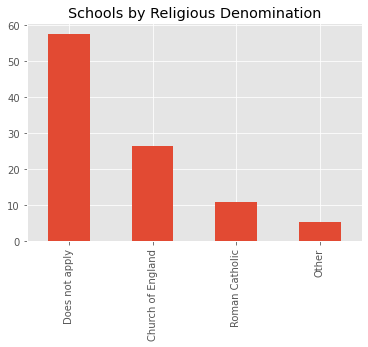

In [71]:
reldenom_percentages = df.RELDENOM.value_counts(normalize=True)*100
reldenom_percentages_short = pd.concat([reldenom_percentages[:'Roman Catholic'], pd.Series({'Other':reldenom_percentages['None':].sum()})]) # Replacing schools from None inclusive by their sum
reldenom_percentages_short.plot(kind='bar', title='Schools by Religious Denomination')

There may be a problem here: 'Does not apply' (and potentially 'None') and 'Unknown' may refer to the same thing, but coded in a different way. Let's take a closer look at these. 

In [72]:
df[df.RELDENOM.isin(['Does not apply', 'None', 'Unknown'])].head(20)

,SCHNAME,TOWN,PCODE,PCON_NAME,NFTYPE,RELDENOM,AGERANGE,PTKS1GROUP_L,PTKS1GROUP_M,PTKS1GROUP_H,PTNotFSM6CLA1A,PTRWM_EXP,PTRWM_HIGH,PTREAD_EXP,PTREAD_HIGH,PTGPS_EXP,PTGPS_HIGH,PTMAT_EXP,PTMAT_HIGH,PTWRITTA_EXP,PTWRITTA_HIGH,PTSCITA_EXP,PTEALGRP1,PSENELE,PSENELK,PTNOTFSM6CLA1A_18,PTRWM_EXP_18,PTRWM_HIGH_18,PTNOTFSM6CLA1A_17,PTRWM_EXP_17,PTRWM_HIGH_17,PTRWM_EXP_3YR,PTRWM_HIGH_3YR
URN,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
141279,Bringhurst Primary School,Market Harborough,LE16 8RH,Rutland and Melton,ACC,Does not apply,4-11,0.00,0.50,0.50,0.85,0.96,0.27,0.96,0.54,0.96,0.62,1.00,0.54,1.00,0.46,1.00,1.00,0.00,0.12,0.92,0.68,0.20,0.88,0.88,0.13,0.84,0.20
119910,Buckminster Primary School,Grantham,NG33 5RZ,Rutland and Melton,CY,Does not apply,4-11,0.06,0.71,0.24,0.88,0.65,0.24,0.82,0.35,0.76,0.29,0.71,0.35,0.94,0.35,0.88,1.00,0.00,0.06,0.84,0.79,0.11,0.87,0.60,0.00,0.69,0.12
139342,Great Dalby School,Melton Mowbray,LE14 2HA,Rutland and Melton,ACC,Does not apply,5-11,0.00,0.57,0.43,0.86,0.86,0.14,0.95,0.38,0.90,0.48,0.95,0.33,0.86,0.38,1.00,1.00,0.00,0.24,0.90,0.80,0.20,0.90,0.80,0.25,0.82,0.20
119912,Burton-on-the-Wolds Primary School,Loughborough,LE12 5TB,Loughborough,CY,Does not apply,4-11,0.04,0.46,0.50,0.88,0.92,0.44,0.96,0.64,0.96,0.68,0.96,0.68,0.92,0.52,0.96,1.00,0.00,0.16,0.86,0.91,0.41,0.92,0.88,0.16,0.90,0.33
119913,Belvoirdale Community Primary School,Coalville,LE67 3RD,North West Leicestershire,CY,Does not apply,4-11,0.15,0.56,0.29,0.74,0.49,0.05,0.56,0.09,0.67,0.28,0.60,0.16,0.67,0.16,0.53,0.74,0.02,0.28,0.66,0.61,0.03,0.65,0.50,0.05,0.53,0.04
119914,Ellistown Community Primary School,Coalville,LE67 1EN,North West Leicestershire,CY,Does not apply,4-11,0.00,0.58,0.42,0.90,0.65,0.19,0.74,0.32,0.90,0.39,0.81,0.32,0.94,0.23,0.90,0.97,0.00,0.00,0.82,0.71,0.18,0.87,0.84,0.16,0.73,0.18
119915,Hugglescote Community Primary School,Coalville,LE67 2HA,North West Leicestershire,CY,Does not apply,4-11,0.18,0.58,0.25,0.77,0.56,0.05,0.58,0.19,0.68,0.33,0.72,0.14,0.72,0.18,0.77,1.00,0.11,0.21,0.88,0.56,0.08,0.90,0.65,0.05,0.59,0.06
119916,Woodstone Community Primary School,Coalville,LE67 2AH,North West Leicestershire,CY,Does not apply,4-11,0.03,0.55,0.42,0.81,0.71,0.10,0.74,0.39,0.84,0.45,0.90,0.32,0.84,0.19,0.90,1.00,0.00,0.13,0.90,0.87,0.10,0.90,0.55,0.06,0.71,0.09
119917,New Swannington Primary School,Coalville,LE67 5DQ,North West Leicestershire,CY,Does not apply,4-11,0.04,0.58,0.38,0.93,0.59,0.19,0.70,0.30,0.63,0.37,0.74,0.30,0.81,0.22,0.81,1.00,0.04,0.22,0.88,0.88,0.17,1.00,0.81,0.08,0.75,0.14


A brief look at the schools with 'Does not apply' under the feature corresponding to their religious denomination suggests that there might be a reason for it. Could it be the case that only schools for *older* children (i.e. non-primary) can have religious denomination? Possibly, but that doesn't seem likely from what we have seen already. Since we are going to compare directly religious and non-religious schools, we need to understand whether they are comparable. 

Let's start by taking a look at age distributions first, between 'Does not apply' (the largest secular category) and 'Church of England' (the largest religious category). Later, we should conduct a more detailed analysis and visualisation, but this is going to be important to get some first ideas. 

In [73]:
df[df.RELDENOM == 'Does not apply'].AGERANGE.value_counts(normalize=True) # normalize for relative frequencies

3-11     0.428946
4-11     0.300072
7-11     0.088579
2-11     0.085598
5-11     0.082022
9-13     0.007272
3-16     0.001311
3-19     0.001192
3-18     0.000954
4-18     0.000477
10-13    0.000477
4-16     0.000358
1-11     0.000358
9-12     0.000358
0-11     0.000358
5-16     0.000238
4-19     0.000238
2-18     0.000238
10-18    0.000119
9-16     0.000119
2-10     0.000119
11-16    0.000119
7-19     0.000119
2-16     0.000119
9-18     0.000119
2-13     0.000119
Name: AGERANGE, dtype: float64

In [74]:
df[df.RELDENOM == 'Church of England'].AGERANGE.value_counts(normalize=True) # normalize for relative frequencies

4-11     0.509148
3-11     0.233926
5-11     0.145321
2-11     0.057501
7-11     0.044171
9-13     0.005489
4-19     0.000784
7-18     0.000523
3-18     0.000523
3-19     0.000523
3-16     0.000523
4-12     0.000261
2-18     0.000261
9-12     0.000261
4-10     0.000261
10-13    0.000261
4-16     0.000261
Name: AGERANGE, dtype: float64

While there are differences in the number of 'ranges' (possibly related to the fact that there are more schools in the former category than in the later), both seem to be overlapping, as they both include children from the age of 2 to the age of 19. This suggests that we can actually compare religious and secular schools. 

To make this comparison easier, let's add a new boolean column 'SECULAR', which will have 1 if RELDENOM is 'Does not apply', 'None', or 'Unknown' and 0 otherwise (strictly speaking, 'Unknown' would be better counted as N/A, but given that there are only 2 such schools, that is likely to be immaterial). 

There are multiple ways to add a new column to a pandas dataframe and populate its values with a condition depending on other column. A more pythonic (and potentially faster, if a vectorised function is used instead of a loop) way to do it will be to use np.where

In [75]:
df['SECULAR'] = np.where(df['RELDENOM'].isin(['Does not apply', 'None', 'Unknown']), 1, 0)

Let's run a quick check. We expect all schools with 1 under SECULAR to have RELDENOM as one of the three above, while all religious schools will be where SECULAR is 0. 

In [76]:
df[df['SECULAR'] == 1]['RELDENOM'].unique()

array(['Does not apply', 'None', 'Unknown'], dtype=object)

In [77]:
df[df['SECULAR'] == 0]['RELDENOM'].unique()

array(['Church of England', 'Roman Catholic', 'Hindu',
       'Church of England/Methodist', 'Christian', 'Methodist', 'Jewish',
       'United Reformed Church', 'Church of England/Utd Reformed Church',
       'Church of England/Roman Catholic', 'Sikh', 'Muslim', 'Catholic',
       'Greek Orthodox', 'Seventh Day Adventist',
       'Church of England/Methodist/Utd Reform Church/Baptist',
       'Roman Catholic/Church of England', 'Anglican',
       'Church of England/Free Church', 'Quaker'], dtype=object)

In [78]:
df['SECULAR'].unique()

array([1, 0])

We can see that this has worked exactly as expected. However, on a second thought, it will be better if we have it more explicit: 'Secular' and 'Religious' instead of 1 and 0. With this, we should also rename the column, since SECULAR suggests a boolean value (RELTYPE would be a more generic name). Both changes are quite easy to do in pandas. 

In [79]:
df.rename(columns={'SECULAR': 'RELTYPE'}, inplace=True)
df['RELTYPE'].replace([0, 1], ['Religious', 'Secular'], inplace=True)
df['RELTYPE'].unique()

array(['Secular', 'Religious'], dtype=object)

In [80]:
df.info() # RELTYPE has 14560 non-null values, which is the same as RELDENOM, as expected

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14560 entries, 141279 to 138492
Data columns (total 34 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   SCHNAME            14560 non-null  object 
 1   TOWN               14560 non-null  object 
 2   PCODE              14560 non-null  object 
 3   PCON_NAME          14560 non-null  object 
 4   NFTYPE             14560 non-null  object 
 5   RELDENOM           14560 non-null  object 
 6   AGERANGE           14560 non-null  object 
 7   PTKS1GROUP_L       14560 non-null  float64
 8   PTKS1GROUP_M       14560 non-null  float64
 9   PTKS1GROUP_H       14560 non-null  float64
 10  PTNotFSM6CLA1A     14560 non-null  float64
 11  PTRWM_EXP          14559 non-null  float64
 12  PTRWM_HIGH         14559 non-null  float64
 13  PTREAD_EXP         14560 non-null  float64
 14  PTREAD_HIGH        14560 non-null  float64
 15  PTGPS_EXP          14559 non-null  float64
 16  PTGPS_HIGH      

Let's take a look whether the means are any different between secular and religious schools. The expectation is that the differences are not going to be statistically significant at all. 

Of special interest will PTKS1GROUP columns (for low, medium, and high Key Stage 1 attainment levels respectively). 

It is important to note that relying only on the means can potentially be misleading (especially if outliers are present), but we will take a look at some other measures of central tendency a bit later. 

In [81]:
df.groupby('RELTYPE').mean()

,PTKS1GROUP_L,PTKS1GROUP_M,PTKS1GROUP_H,PTNotFSM6CLA1A,PTRWM_EXP,PTRWM_HIGH,PTREAD_EXP,PTREAD_HIGH,PTGPS_EXP,PTGPS_HIGH,PTMAT_EXP,PTMAT_HIGH,PTWRITTA_EXP,PTWRITTA_HIGH,PTSCITA_EXP,PTEALGRP1,PSENELE,PSENELK,PTNOTFSM6CLA1A_18,PTRWM_EXP_18,PTRWM_HIGH_18,PTNOTFSM6CLA1A_17,PTRWM_EXP_17,PTRWM_HIGH_17,PTRWM_EXP_3YR,PTRWM_HIGH_3YR
RELTYPE,,,,,,,,,,,,,,,,,,,,,,,,,,
Religious,0.066570,0.575971,0.357675,0.760635,0.681157,0.113646,0.776043,0.302665,0.809017,0.366915,0.808990,0.274697,0.807943,0.216707,0.860983,0.866818,0.01873,0.149716,0.759927,0.677755,0.109201,0.752076,0.649284,0.100093,0.669287,0.111163
Secular,0.085295,0.585606,0.329462,0.671215,0.649373,0.100379,0.735985,0.263341,0.781968,0.343538,0.791391,0.256605,0.791866,0.199852,0.837627,0.815628,0.02241,0.158138,0.666519,0.644152,0.094371,0.655791,0.612034,0.083130,0.637140,0.095323


The table above is useful, but not too convenient to check, particularly across all columns. Let's visualise it using seaborn. However, before doing that we need to stack the dataframe (i.e. to convert if from 'wide' to 'long')

In [82]:
df_secular_groups = df.groupby('RELTYPE').mean().stack()
df_secular_groups=df_secular_groups.to_frame()
df_secular_groups.reset_index(inplace=True)
df_secular_groups.columns = ['reltype', 'category', 'mean']

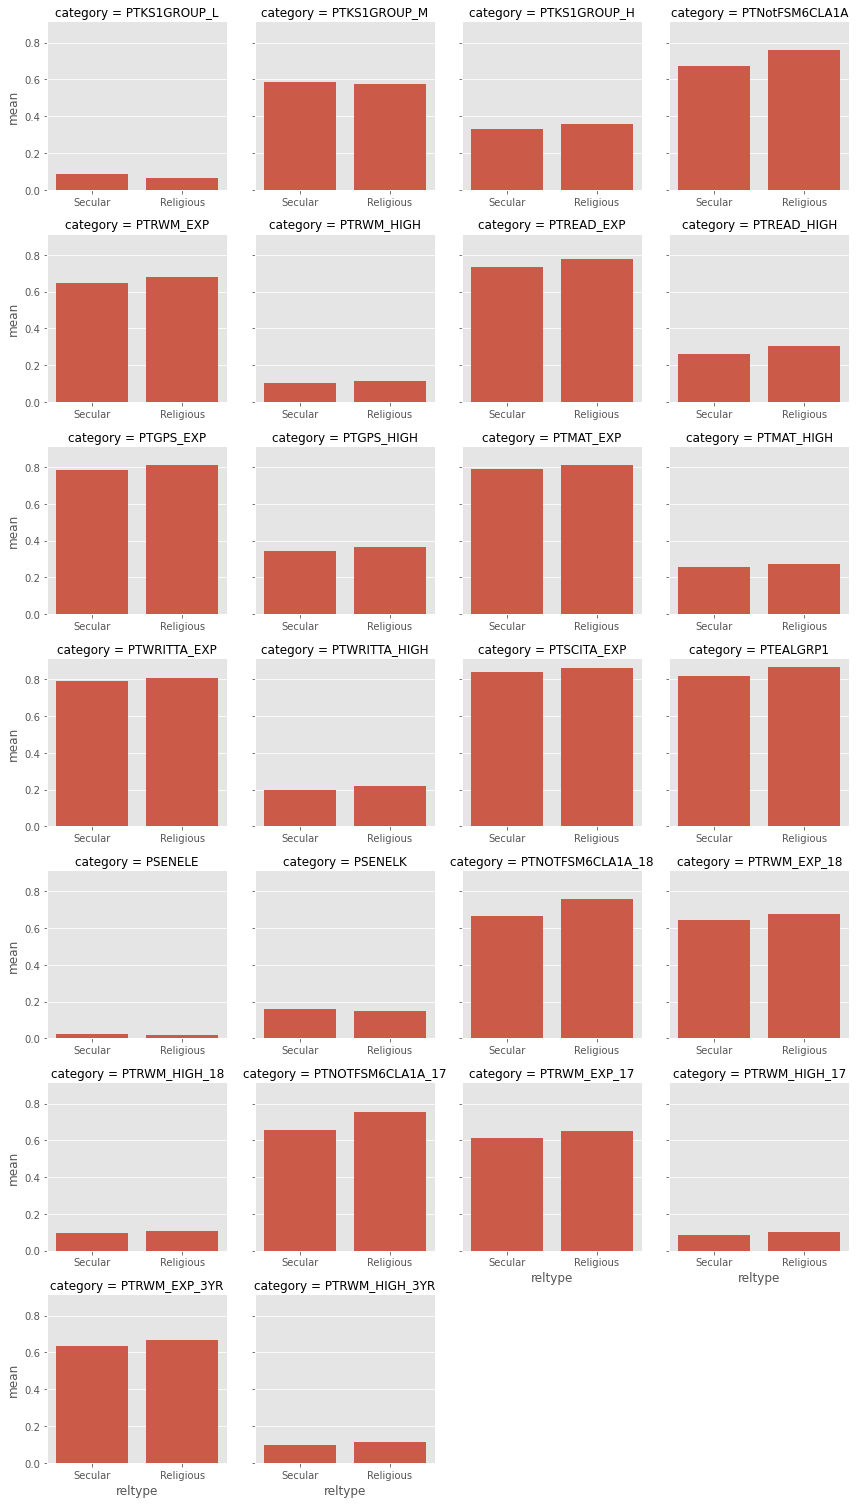

In [83]:
g = sns.FacetGrid(df_secular_groups, col='category', col_wrap=4, margin_titles=True, legend_out=True, sharex=False)
g.map(sns.barplot, 'reltype', 'mean', order=['Secular', 'Religious'])

The results for KS1 attainments look comparable for both groups, and so are percentages for reading, writing, and math (PTRWM), reading (PTREAD), grammar, punctuation, and spelling (PTGPS), mathematics (PTMAT), writing (PTWRITTA), science (PTSCITA).  Comparable results can be seen for prior years' data (the rightmost columns in the table above). 

The data above are useful, but the comparison above was quite high-level. Specifically, it was done only for the *means* of the features, which may have been affected by outliers (the main suspect is PTNotFSM6CLA1A, percentage of children who are not disadvantaged, where we *do* see an apparent difference between religious and non-religious schools). Can we take a look a other measures of central tendency, and perhaps even visualise the outliers, if any? We certainly do, and the way to do it is to use box plots. Likewise, let's convert the dataframe from wide to long format by stacking, and use seaborn afterwards. 

In [84]:
cols = df.groupby('RELTYPE').mean().columns # to get the same (numerical) columns as in the table above
df_long = df[cols].stack()
df_long=df_long.to_frame()
df_long.reset_index(inplace=True)
df_long.columns = ['urn', 'category', 'value']
df_long['reltype'] = np.where(df_long['urn'].isin(df[df['RELTYPE']=='Secular'].index), 'Secular', 'Religious')

In [85]:
set(df[df['RELTYPE']=='Secular'].index) - set(df_long[df_long['reltype']=='Secular']['urn']) # a quick check to ensure that secular columns contain the same unique values

set()

In [86]:
set(df[df['RELTYPE']=='Religious'].index) - set(df_long[df_long['reltype']=='Religious']['urn'])

set()

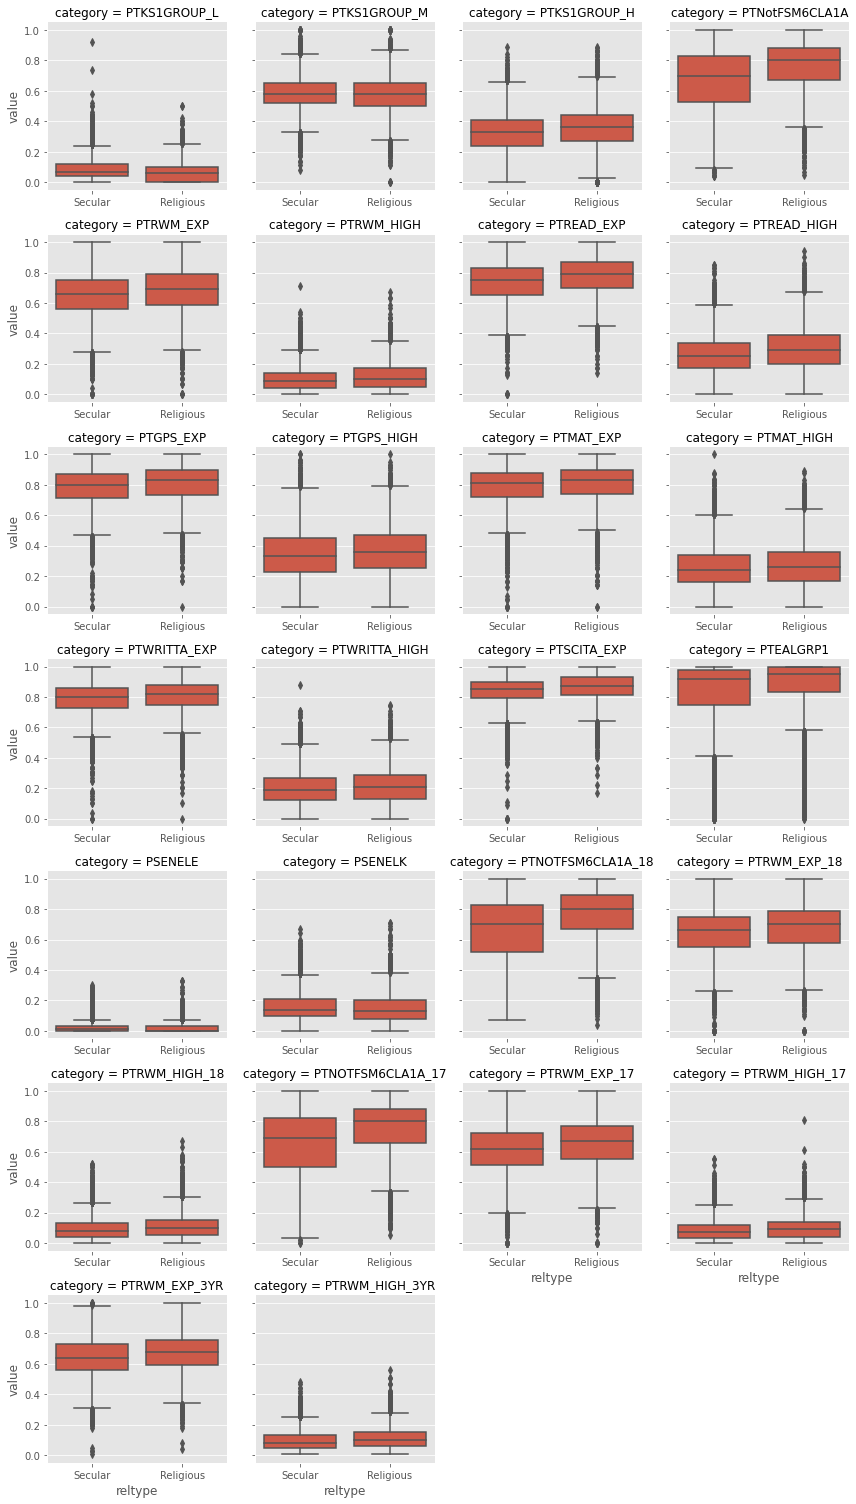

In [87]:
g = sns.FacetGrid(df_long, col='category', col_wrap=4, margin_titles=True, legend_out=True, sharex=False)
g.map(sns.boxplot, 'reltype', 'value', order=['Secular', 'Religious'])

Let us remind what the boxes in the plots above actually represent. The boxes visualise the distributions across categories, for secular and religious schools (the left box and right box respectively). The horizontal lines in the middle of these boxes are medians (which, unlike means, are not affected by outliers). The box itself shows four quartiles, with its borders standing for first and third quartiles. The whiskers, in addition to box borders, stand for minimum and maximum, and outliers are shown as individual black dots. 

We can, however, take this one step further and also plot the *distributions* across different categories. This will require a different type of a plot, the violin plot specifically. However, before we go there, let's run summary statistics across the two categories, to show the data in the tabular form first. 

In [88]:
df[df.RELTYPE == 'Religious'].describe()

,PTKS1GROUP_L,PTKS1GROUP_M,PTKS1GROUP_H,PTNotFSM6CLA1A,PTRWM_EXP,PTRWM_HIGH,PTREAD_EXP,PTREAD_HIGH,PTGPS_EXP,PTGPS_HIGH,PTMAT_EXP,PTMAT_HIGH,PTWRITTA_EXP,PTWRITTA_HIGH,PTSCITA_EXP,PTEALGRP1,PSENELE,PSENELK,PTNOTFSM6CLA1A_18,PTRWM_EXP_18,PTRWM_HIGH_18,PTNOTFSM6CLA1A_17,PTRWM_EXP_17,PTRWM_HIGH_17,PTRWM_EXP_3YR,PTRWM_HIGH_3YR
count,5557.000000,5557.000000,5557.000000,5557.000000,5557.000000,5557.000000,5557.000000,5557.000000,5556.000000,5556.000000,5557.00000,5557.000000,5557.000000,5557.000000,5557.000000,5557.000000,5557.000000,5557.000000,5456.000000,5456.000000,5456.000000,5366.000000,5366.000000,5366.000000,5457.000000,5270.000000
mean,0.066570,0.575971,0.357675,0.760635,0.681157,0.113646,0.776043,0.302665,0.809017,0.366915,0.80899,0.274697,0.807943,0.216707,0.860983,0.866818,0.018730,0.149716,0.759927,0.677755,0.109201,0.752076,0.649284,0.100093,0.669287,0.111163
std,0.064821,0.123672,0.136642,0.169093,0.151062,0.087626,0.129564,0.138346,0.126375,0.167265,0.13177,0.145400,0.111256,0.118889,0.098989,0.193294,0.032167,0.097350,0.173174,0.158019,0.086373,0.179279,0.161267,0.082203,0.128446,0.065550
min,0.000000,0.000000,0.000000,0.050000,0.000000,0.000000,0.140000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.170000,0.000000,0.000000,0.000000,0.040000,0.000000,0.000000,0.050000,0.000000,0.000000,0.040000,0.010000
25%,0.000000,0.500000,0.270000,0.670000,0.590000,0.050000,0.700000,0.200000,0.730000,0.250000,0.74000,0.170000,0.750000,0.130000,0.810000,0.830000,0.000000,0.080000,0.670000,0.580000,0.050000,0.660000,0.550000,0.040000,0.590000,0.060000
50%,0.060000,0.580000,0.360000,0.800000,0.690000,0.100000,0.790000,0.290000,0.830000,0.360000,0.83000,0.260000,0.820000,0.210000,0.870000,0.950000,0.000000,0.130000,0.800000,0.700000,0.100000,0.800000,0.670000,0.090000,0.680000,0.100000
75%,0.100000,0.650000,0.440000,0.880000,0.790000,0.170000,0.870000,0.390000,0.900000,0.470000,0.90000,0.360000,0.880000,0.290000,0.930000,1.000000,0.030000,0.200000,0.890000,0.790000,0.150000,0.880000,0.770000,0.140000,0.760000,0.150000
max,0.500000,1.000000,0.890000,1.000000,1.000000,0.670000,1.000000,0.940000,1.000000,1.000000,1.00000,0.890000,1.000000,0.750000,1.000000,1.000000,0.330000,0.710000,1.000000,1.000000,0.670000,1.000000,1.000000,0.810000,1.000000,0.560000


In [89]:
df[df.RELTYPE == 'Secular'].describe()

,PTKS1GROUP_L,PTKS1GROUP_M,PTKS1GROUP_H,PTNotFSM6CLA1A,PTRWM_EXP,PTRWM_HIGH,PTREAD_EXP,PTREAD_HIGH,PTGPS_EXP,PTGPS_HIGH,PTMAT_EXP,PTMAT_HIGH,PTWRITTA_EXP,PTWRITTA_HIGH,PTSCITA_EXP,PTEALGRP1,PSENELE,PSENELK,PTNOTFSM6CLA1A_18,PTRWM_EXP_18,PTRWM_HIGH_18,PTNOTFSM6CLA1A_17,PTRWM_EXP_17,PTRWM_HIGH_17,PTRWM_EXP_3YR,PTRWM_HIGH_3YR
count,9003.000000,9003.000000,9003.000000,9003.000000,9002.000000,9002.000000,9003.000000,9003.000000,9003.000000,9003.000000,9002.000000,9002.000000,9003.000000,9003.000000,9003.000000,9003.000000,9003.000000,9003.000000,8948.000000,8946.000000,8946.000000,8697.000000,8696.000000,8696.000000,8724.000000,8536.000000
mean,0.085295,0.585606,0.329462,0.671215,0.649373,0.100379,0.735985,0.263341,0.781968,0.343538,0.791391,0.256605,0.791866,0.199852,0.837627,0.815628,0.022410,0.158138,0.666519,0.644152,0.094371,0.655791,0.612034,0.083130,0.637140,0.095323
std,0.068302,0.109356,0.129180,0.192815,0.147727,0.076109,0.131927,0.125553,0.124618,0.158237,0.125759,0.134093,0.107126,0.110695,0.100366,0.240430,0.031665,0.089986,0.196855,0.154658,0.074467,0.202003,0.159379,0.069742,0.129431,0.059402
min,0.000000,0.080000,0.000000,0.040000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.070000,0.000000,0.000000,0.000000,0.000000,0.000000,0.010000,0.010000
25%,0.040000,0.520000,0.240000,0.530000,0.560000,0.040000,0.650000,0.170000,0.710000,0.230000,0.720000,0.160000,0.730000,0.120000,0.790000,0.750000,0.000000,0.100000,0.520000,0.550000,0.040000,0.500000,0.510000,0.030000,0.560000,0.050000
50%,0.070000,0.580000,0.330000,0.700000,0.660000,0.090000,0.750000,0.250000,0.800000,0.330000,0.810000,0.240000,0.800000,0.190000,0.850000,0.920000,0.010000,0.140000,0.700000,0.660000,0.080000,0.690000,0.620000,0.070000,0.640000,0.080000
75%,0.120000,0.650000,0.410000,0.830000,0.750000,0.140000,0.830000,0.340000,0.870000,0.450000,0.880000,0.337500,0.860000,0.270000,0.900000,0.980000,0.030000,0.210000,0.830000,0.750000,0.130000,0.820000,0.720000,0.120000,0.730000,0.130000
max,0.920000,1.000000,0.890000,1.000000,1.000000,0.710000,1.000000,0.850000,1.000000,1.000000,1.000000,1.000000,1.000000,0.880000,1.000000,1.000000,0.300000,0.670000,1.000000,1.000000,0.520000,1.000000,1.000000,0.550000,1.000000,0.480000


Now let's show this using a similar grid, but this time containing violin plots. 

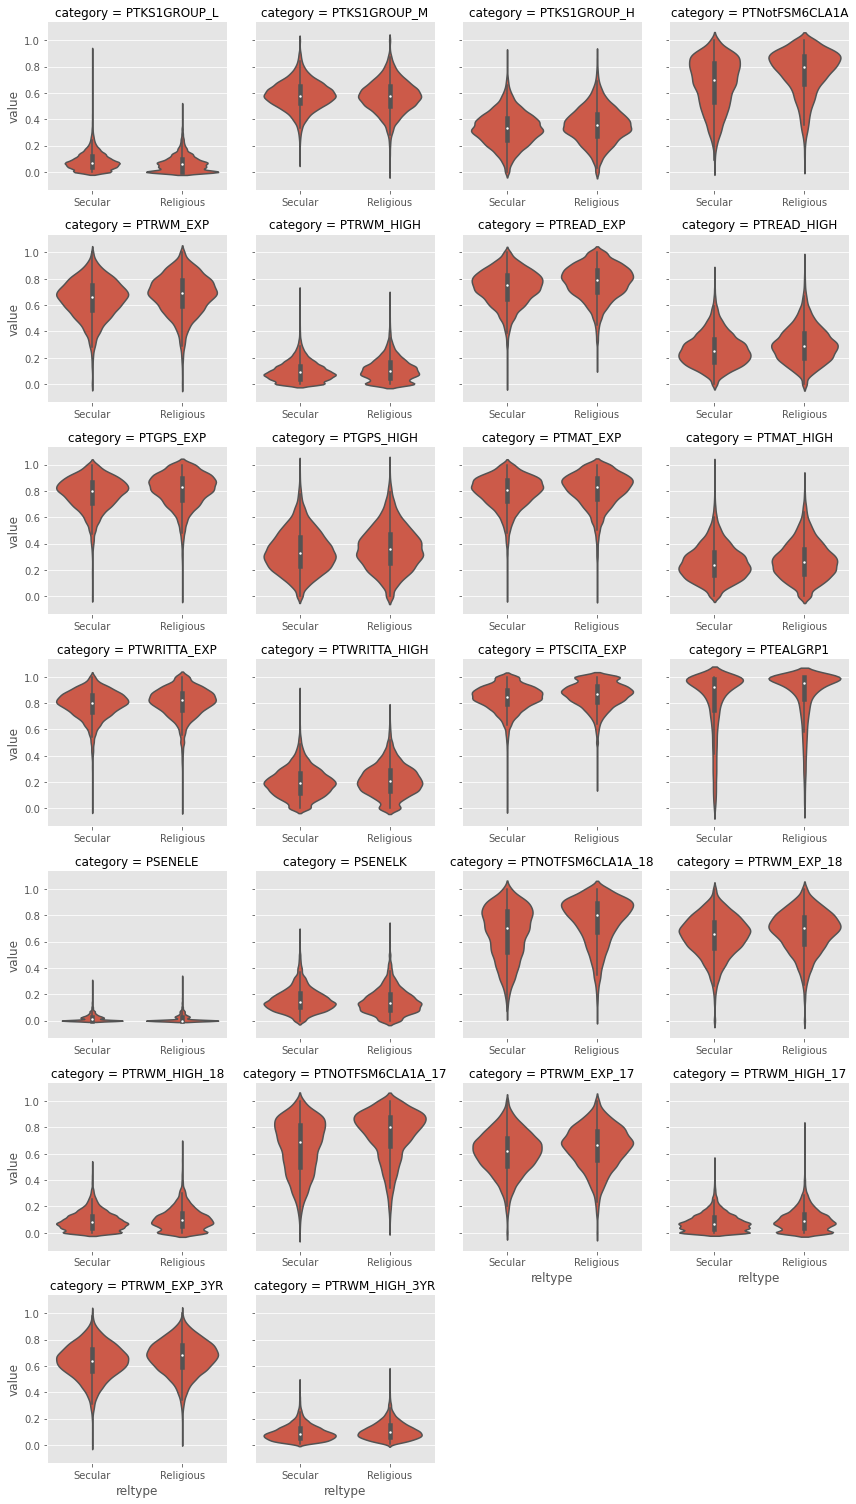

In [90]:
g = sns.FacetGrid(df_long, col='category', col_wrap=4, margin_titles=True, legend_out=True, sharex=False)
g.map(sns.violinplot, 'reltype', 'value', split=True, order=['Secular', 'Religious'])

We can see in the grids above that most figures (both 'boxes' and 'violins') are comparable, across most categories, between secular and religious schools. Where we *do* see an apparent difference is in statistics for key stage 2 children (age 7-11) who are not disadvantaged (PTNotFSM6CLA1A, in the top right corner). For these columns (including prior year's data), there is a difference which seems to be too large to be a chance. Why is it different? There is no obvious answer yet, but it may have something to do with outliers (we can see more black dots in the top-right chart for religious schools in the box plot, and also a longer lower 'tail' in the violin plot), and we need to take a closer look there. 

In [91]:
df[df.RELTYPE == 'Secular'].sort_values(by='PTNotFSM6CLA1A', ascending=True)[['SCHNAME', 'TOWN', 'NFTYPE', 'RELDENOM', 'AGERANGE', 'PTNotFSM6CLA1A']]

,SCHNAME,TOWN,NFTYPE,RELDENOM,AGERANGE,PTNotFSM6CLA1A
URN,,,,,,
106690,Marshland Primary School,Doncaster,CY,Does not apply,2-11,0.04
105055,Leasowe Primary School,Wirral,CY,Does not apply,4-11,0.04
112573,Kensington Junior School,Ilkeston,CY,Does not apply,7-11,0.04
105412,Crosslee Community Primary School,Manchester,CY,Does not apply,3-11,0.05
112632,Arkwright Primary School,Chesterfield,CY,Does not apply,3-11,0.06
...,...,...,...,...,...,...
123030,Stadhampton Primary School,Oxford,CY,Does not apply,5-11,1.00
124615,Waldringfield Primary School,Woodbridge,CY,Does not apply,4-11,1.00
123036,Mill Lane Community Primary School,Chinnor,CY,Does not apply,3-11,1.00


We can see in the table above that there are certain schools where only 4-5% of children are *not* disadvantaged, which are also secular (and are community schools, as suggested by CY under NFTYPE). Let's take a look at the top two, Marshland Primary School and Leasowe Primary School. A quick glance on their details from the government website suggests that this is correct. We can also see that in both schools there is quite a large percentage of students who are eligible for free school meals, another indicator of potential disadvantages. 

https://www.get-information-schools.service.gov.uk/Establishments/Establishment/Details/117937

https://www.get-information-schools.service.gov.uk/Establishments/Establishment/Details/105055

Let's see how it looks for religious schools. 

In [92]:
df[df.RELTYPE == 'Religious'].sort_values(by='PTNotFSM6CLA1A', ascending=True)[['SCHNAME', 'TOWN', 'NFTYPE', 'RELDENOM', 'AGERANGE', 'PTNotFSM6CLA1A']]

,SCHNAME,TOWN,NFTYPE,RELDENOM,AGERANGE,PTNotFSM6CLA1A
URN,,,,,,
136943,Ward Jackson Church of England VA Primary School,Hartlepool,VA,Church of England,3-11,0.05
105087,Holy Cross Catholic Primary School,Birkenhead,VA,Roman Catholic,3-11,0.07
138584,Christ Church CE Academy,Huddersfield,AC,Church of England,3-11,0.09
139269,Hawkesley Church Primary Academy,Birmingham,AC,Church of England/Methodist,3-11,0.10
103404,St Matthew's CofE Primary School,Birmingham,VC,Church of England,4-11,0.11
...,...,...,...,...,...,...
145076,Clutton Church of England Primary School,Chester,ACC,Church of England,3-11,1.00
121092,Harpley CofE VC Primary School,King's Lynn,VC,Church of England,4-11,1.00
115191,Radwinter Church of England Voluntary Aided Pr...,Saffron Walden,VA,Church of England,5-11,1.00


Low figures for some schools under the PTNotFSM6CLA1A column also suggest some schools (now religious, not secular) with predominantly disadvantaged students. However, to have a more complete picture, let's check some statistics by the same categories (religious and secular) and . For this, we can use the qcut and pivot_table functions.

In [93]:
sections = pd.cut(df['PTNotFSM6CLA1A'], bins=np.arange(0, 1.1, 0.1))
pd.crosstab(sections, df['RELTYPE'], margins=True)

RELTYPE,Religious,Secular,All
PTNotFSM6CLA1A,,,
"(0.0, 0.1]",4,15,19
"(0.1, 0.2]",15,77,92
"(0.2, 0.3]",66,300,366
"(0.3, 0.4]",174,595,769
"(0.4, 0.5]",279,977,1256
"(0.5, 0.6]",442,1128,1570
"(0.6, 0.7]",692,1517,2209
"(0.7, 0.8]",1226,1745,2971
"(0.8, 0.9]",1625,1847,3472


In [94]:
len(df) # The total for PTNotFSM6CLA1A is 14560, which is the same as the grand total in the bottom right corner of the table above

14560

The table above shows us that out of 14560 schools, there are 19 where only 10% or less of their students are *not* disadvantaged (4 religious and 15 secular). This is 0.13% of the total. Let's take a look at these schools. 

In [95]:
df[(df['PTNotFSM6CLA1A'] <= 0.1) & (df['RELTYPE'] == 'Religious')] # Only 4 schools indeed, just as in the table above (religious and with less than 10% of students not disadvantaged)

,SCHNAME,TOWN,PCODE,PCON_NAME,NFTYPE,RELDENOM,AGERANGE,PTKS1GROUP_L,PTKS1GROUP_M,PTKS1GROUP_H,PTNotFSM6CLA1A,PTRWM_EXP,PTRWM_HIGH,PTREAD_EXP,PTREAD_HIGH,PTGPS_EXP,PTGPS_HIGH,PTMAT_EXP,PTMAT_HIGH,PTWRITTA_EXP,PTWRITTA_HIGH,PTSCITA_EXP,PTEALGRP1,PSENELE,PSENELK,PTNOTFSM6CLA1A_18,PTRWM_EXP_18,PTRWM_HIGH_18,PTNOTFSM6CLA1A_17,PTRWM_EXP_17,PTRWM_HIGH_17,PTRWM_EXP_3YR,PTRWM_HIGH_3YR,RELTYPE
URN,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
136943,Ward Jackson Church of England VA Primary School,Hartlepool,TS24 7LE,Hartlepool,VA,Church of England,3-11,0.24,0.65,0.12,0.05,0.58,0.00,0.58,0.11,0.89,0.16,0.89,0.37,0.89,0.26,0.89,0.74,0.05,0.26,0.14,0.77,0.05,0.21,0.36,0.0,0.60,0.02,Religious
139269,Hawkesley Church Primary Academy,Birmingham,B38 9TR,"Birmingham, Northfield",AC,Church of England/Methodist,3-11,0.00,0.79,0.21,0.10,0.52,0.03,0.63,0.10,0.60,0.17,0.57,0.07,0.76,0.03,0.79,0.90,0.03,0.20,0.13,0.35,0.03,0.16,0.32,0.0,0.41,0.03,Religious
105087,Holy Cross Catholic Primary School,Birkenhead,CH41 7DU,Birkenhead,VA,Roman Catholic,3-11,0.07,0.80,0.13,0.07,0.53,0.00,0.67,0.20,0.67,0.13,0.60,0.00,0.67,0.13,0.73,1.00,0.00,0.40,0.17,0.43,0.04,0.05,0.30,0.0,0.41,0.02,Religious
138584,Christ Church CE Academy,Huddersfield,HD2 1JP,Huddersfield,AC,Church of England,3-11,0.05,0.77,0.18,0.09,0.57,0.13,0.57,0.13,0.83,0.35,0.83,0.26,0.78,0.13,0.78,0.57,0.00,0.35,0.18,0.39,0.00,0.34,0.36,0.0,0.43,0.04,Religious


In [96]:
df[(df['PTNotFSM6CLA1A'] <= 0.1) & (df['RELTYPE'] == 'Secular')]

,SCHNAME,TOWN,PCODE,PCON_NAME,NFTYPE,RELDENOM,AGERANGE,PTKS1GROUP_L,PTKS1GROUP_M,PTKS1GROUP_H,PTNotFSM6CLA1A,PTRWM_EXP,PTRWM_HIGH,PTREAD_EXP,PTREAD_HIGH,PTGPS_EXP,PTGPS_HIGH,PTMAT_EXP,PTMAT_HIGH,PTWRITTA_EXP,PTWRITTA_HIGH,PTSCITA_EXP,PTEALGRP1,PSENELE,PSENELK,PTNOTFSM6CLA1A_18,PTRWM_EXP_18,PTRWM_HIGH_18,PTNOTFSM6CLA1A_17,PTRWM_EXP_17,PTRWM_HIGH_17,PTRWM_EXP_3YR,PTRWM_HIGH_3YR,RELTYPE
URN,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
107928,Seacroft Grange Primary School,Leeds,LS14 6JR,Leeds East,CY,Does not apply,4-11,0.21,0.68,0.11,0.10,0.43,0.03,0.70,0.37,0.70,0.20,0.67,0.03,0.50,0.10,0.43,0.90,0.03,0.13,0.28,0.59,0.10,0.34,0.41,0.03,0.48,0.06,Secular
143271,Cheviot Primary School,Newcastle-upon-Tyne,NE5 4EB,Newcastle upon Tyne North,ACC,Does not apply,3-11,0.15,0.63,0.22,0.07,0.89,0.04,0.89,0.11,0.81,0.26,0.89,0.30,0.93,0.22,0.93,0.96,0.04,0.22,0.24,0.80,0.20,0.29,0.90,0.05,0.86,0.10,Secular
100916,Olga Primary School,London,E3 5DN,Bethnal Green and Bow,CY,Does not apply,3-11,0.04,0.70,0.26,0.10,0.77,0.13,0.90,0.33,0.93,0.40,0.93,0.27,0.83,0.17,0.87,0.30,0.00,0.20,0.45,0.72,0.14,0.40,0.63,0.03,0.71,0.10,Secular
140855,West Town Primary Academy,Peterborough,PE3 6DD,Peterborough,AC,Does not apply,4-11,0.07,0.73,0.20,0.09,0.56,0.09,0.56,0.18,0.73,0.38,0.71,0.27,0.84,0.16,0.87,0.09,0.02,0.11,0.76,0.66,0.07,0.62,0.51,0.05,0.58,0.07,Secular
141165,Queen Elizabeth's Grammar School,Blackburn,BB2 6DF,Blackburn,F,None,4-19,0.00,0.76,0.24,0.08,0.82,0.11,0.87,0.26,0.97,0.39,0.92,0.37,0.87,0.24,0.92,0.82,0.03,0.08,0.85,0.59,0.12,0.88,0.68,0.05,0.69,0.09,Secular
144945,Westminster Primary Academy,Blackpool,FY1 2QE,Blackpool North and Cleveleys,ACC,Does not apply,4-11,0.15,0.68,0.17,0.10,0.67,0.02,0.71,0.31,0.67,0.22,0.80,0.29,0.71,0.02,0.71,0.98,0.00,0.53,0.16,0.65,0.07,0.18,0.61,0.04,0.64,0.04,Secular
103267,Court Farm Primary School,Birmingham,B23 5NS,"Birmingham, Erdington",CY,Does not apply,3-11,0.14,0.69,0.17,0.10,0.48,0.03,0.62,0.24,0.72,0.31,0.59,0.14,0.69,0.14,0.76,0.62,0.00,0.21,0.23,0.37,0.00,0.21,0.55,0.00,0.47,0.01,Secular
112573,Kensington Junior School,Ilkeston,DE7 5PA,Erewash,CY,Does not apply,7-11,0.13,0.51,0.36,0.04,0.49,0.02,0.53,0.13,0.62,0.21,0.72,0.11,0.77,0.17,0.72,0.96,0.02,0.23,0.55,0.42,0.04,0.63,0.47,0.00,0.46,0.02,Secular
112632,Arkwright Primary School,Chesterfield,S44 5BZ,Bolsover,CY,Does not apply,3-11,0.00,0.76,0.24,0.06,0.47,0.12,0.71,0.18,0.71,0.24,0.65,0.18,0.82,0.24,0.82,1.00,0.00,0.18,0.33,0.73,0.13,0.56,1.00,0.11,0.68,0.12,Secular


In [97]:
df[(df['PTNotFSM6CLA1A'] <= 0.1) & (df['RELTYPE'] == 'Secular')].shape[0] # 15 schools indeed (secular and with less than 10% of students not disadvantaged)

15

In [98]:
pd.crosstab(sections, df['RELTYPE'], margins=True, normalize=True)*100 # To show percentages of each category

RELTYPE,Religious,Secular,All
PTNotFSM6CLA1A,,,
"(0.0, 0.1]",0.027473,0.103022,0.130495
"(0.1, 0.2]",0.103022,0.528846,0.631868
"(0.2, 0.3]",0.453297,2.060440,2.513736
"(0.3, 0.4]",1.195055,4.086538,5.281593
"(0.4, 0.5]",1.916209,6.710165,8.626374
"(0.5, 0.6]",3.035714,7.747253,10.782967
"(0.6, 0.7]",4.752747,10.418956,15.171703
"(0.7, 0.8]",8.420330,11.984890,20.405220
"(0.8, 0.9]",11.160714,12.685440,23.846154


In [99]:
# Notice that here we multipy and divide pandas Series by scalars, which is known as broadcasting
reltype_crosstab = pd.crosstab(sections, df['RELTYPE'], margins=True)
reltype_crosstab['Religious'] = 100 * reltype_crosstab['Religious'] / len(df[df['RELTYPE']=='Religious']) 
reltype_crosstab['Secular'] = 100 * reltype_crosstab['Secular'] / len(df[df['RELTYPE']=='Secular'])
reltype_crosstab['All'] = 100 * reltype_crosstab['All'] / len(df['RELTYPE'])
reltype_crosstab

RELTYPE,Religious,Secular,All
PTNotFSM6CLA1A,,,
"(0.0, 0.1]",0.071981,0.166611,0.130495
"(0.1, 0.2]",0.269930,0.855270,0.631868
"(0.2, 0.3]",1.187691,3.332223,2.513736
"(0.3, 0.4]",3.131186,6.608908,5.281593
"(0.4, 0.5]",5.020695,10.851938,8.626374
"(0.5, 0.6]",7.953932,12.529157,10.782967
"(0.6, 0.7]",12.452762,16.849939,15.171703
"(0.7, 0.8]",22.062264,19.382428,20.405220
"(0.8, 0.9]",29.242397,20.515384,23.846154


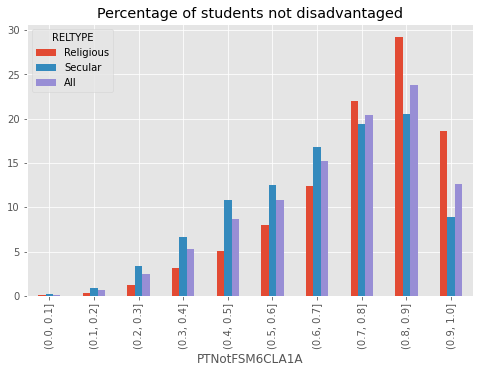

In [100]:
reltype_crosstab.iloc[:-1, :].plot(kind='bar', title='Percentage of students not disadvantaged', figsize=(8, 5))

The table and plot above show us that, in general, there are more disadvantaged students in secular schools. However, at the 'higher' end (more than 70% of students are not disadvantaged), religious schools show considerably higher percentages. 

Some spot checks show that these figures are not incorrect. One example is Ward Jackson Church of England VA Primary School in a table above (religious). It is easy to find that it recently had 18 disadvantaged students out of 19 total, which explains why the figure in the PTNotFSM6CLA1A column was so low. Likewise for Seacroft Grange Primary School: 27 disadvantaged pupils out of 30 total.

https://www.compare-school-performance.service.gov.uk/school/136943/ward-jackson-church-of-england-va-primary-school/primary/results-by-pupil-characteristics?accordionstate=0|1

https://www.compare-school-performance.service.gov.uk/school/107928/seacroft-grange-primary-school/primary/results-by-pupil-characteristics?accordionstate=0|1

## School Comparison by School Type

In general, school types are not expected to play an important role in the context of this analysis. While they *are* definitely important on a higher level, it is important to remind that this analysis focuses only on primary education, for younger children, and hence omits a large number of schools which admit only older students. Nevertheless, it may be still helpful to check how schools of different types performed, as this information may be useful for further analysis. 

To start, let's check which schools types are available and what these school type codes actually represent. 

In [101]:
df['NFTYPE'].unique()

array(['ACC', 'CY', 'AC', 'VC', 'VA', 'F', 'FD'], dtype=object)

According to the table provided at the beginning of the notebook (Feature Selection section), the codes can be interpreted as below:
AC = Academy Sponsor Led (NFTYPE 20), 
CY = Community school (21), 
VA = Voluntary Aided school (22), 
VC = Voluntary Controlled school (23), 
FD = Foundation school (24), 
CTC = City Technology College (25), 
ACC = Academy converter (51), 
F = Free school (52). Rectype 2: 
CYS = Community special (26), 
FDS = Foundation special (27), 
ACS = Academy special (50), 
FS = Free Special School (53), 
ACCS = Academy Converter Special (55)

Working with the codes may not be the most convenient way to conduct our analysis, and we can replace them. 

In [102]:
nftype_dict = {
    'ACC': 'Academy converter',
    'CY': 'Community school',
    'AC': 'Academy sponsor-led',
    'VC': 'Voluntary-controlled school',
    'VA': 'Voluntary-aided school',
    'F': 'Free school',
    'FD': 'Foundation school'
}
df.replace({'NFTYPE':nftype_dict}, inplace=True)

In [103]:
df['NFTYPE'].unique()

array(['Academy converter', 'Community school', 'Academy sponsor-led',
       'Voluntary-controlled school', 'Voluntary-aided school',
       'Free school', 'Foundation school'], dtype=object)

Let's check how many schools are in each category

In [104]:
vc1 = df['NFTYPE'].value_counts(normalize=False)
vc2 = df['NFTYPE'].value_counts(normalize=True) * 100
vc_df = pd.concat([vc1, vc2], axis=1)
vc_df.columns = ['Count', 'Percentage']
vc_df.loc['Total'] = vc_df.sum()
vc_df

,Count,Percentage
Community school,5415.0,37.190934
Academy converter,3263.0,22.410714
Voluntary-aided school,2586.0,17.760989
Voluntary-controlled school,1587.0,10.899725
Academy sponsor-led,1141.0,7.836538
Foundation school,515.0,3.537088
Free school,53.0,0.364011
Total,14560.0,100.000000


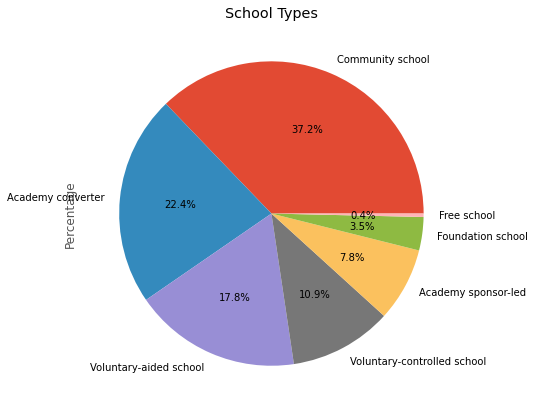

In [105]:
vc_df.iloc[:-1,:].plot.pie(y='Percentage', figsize=(7, 7), autopct='%1.1f%%', legend=False, title='School Types')

Let's run a pivot table to compare median values across the three columns corresponding to KS1 attainment (low, medium, and high respectively)

In [106]:
schtype_pivot = df.pivot_table(['PTKS1GROUP_H', 'PTKS1GROUP_M', 'PTKS1GROUP_L'], index='NFTYPE', aggfunc=np.median, margins=True)
schtype_pivot

,PTKS1GROUP_H,PTKS1GROUP_L,PTKS1GROUP_M
NFTYPE,,,
Academy converter,0.35,0.06,0.58
Academy sponsor-led,0.27,0.10,0.61
Community school,0.33,0.07,0.58
Foundation school,0.32,0.07,0.60
Free school,0.35,0.05,0.60
Voluntary-aided school,0.35,0.06,0.58
Voluntary-controlled school,0.36,0.05,0.57
All,0.33,0.07,0.58


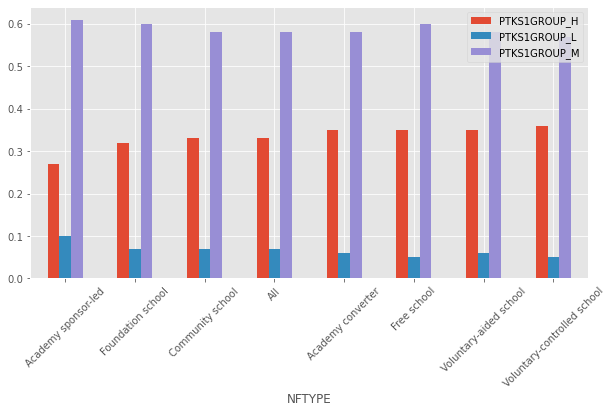

In [107]:
schtype_pivot.sort_values(by='PTKS1GROUP_H').plot(kind='bar', figsize=(10, 5), rot=45)

The pivot table and bar chart above suggest that all these types of schools (expect, perhaps, academy sponsor-led) are probably not much different. While the medians are, of course, not exactly the same, we do not know yet whether the differences we have seen are statistically significant. Moreover, above we have seen only three features, and we may as well take a look at some others (there might, for example, be some evidence that, say, free schools are better for mathematics). 

As a first step, we can run the same pivot tables as above, but with more features. Later, we will conduct analysis of variance (ANOVA) to check whether the differences are statistically significant.

In [108]:
cols = ["PTKS1GROUP_L", "PTKS1GROUP_M", "PTKS1GROUP_H", "PTNotFSM6CLA1A",
        "PTRWM_EXP", "PTRWM_HIGH", "PTREAD_EXP", "PTREAD_HIGH", "PTGPS_EXP",
        "PTGPS_HIGH", "PTMAT_EXP", "PTMAT_HIGH", "PTWRITTA_EXP", "PTWRITTA_HIGH",
        "PTSCITA_EXP"]
schtype_pivot = df.pivot_table(cols, index='NFTYPE', aggfunc=np.median, margins=True)
schtype_pivot

,PTGPS_EXP,PTGPS_HIGH,PTKS1GROUP_H,PTKS1GROUP_L,PTKS1GROUP_M,PTMAT_EXP,PTMAT_HIGH,PTNotFSM6CLA1A,PTREAD_EXP,PTREAD_HIGH,PTRWM_EXP,PTRWM_HIGH,PTSCITA_EXP,PTWRITTA_EXP,PTWRITTA_HIGH
NFTYPE,,,,,,,,,,,,,,,
Academy converter,0.81,0.35,0.35,0.06,0.58,0.83,0.26,0.76,0.77,0.28,0.690,0.10,0.86,0.82,0.21
Academy sponsor-led,0.73,0.27,0.27,0.10,0.61,0.75,0.19,0.56,0.69,0.19,0.600,0.06,0.80,0.77,0.16
Community school,0.81,0.34,0.33,0.07,0.58,0.81,0.25,0.71,0.75,0.26,0.670,0.09,0.85,0.80,0.20
Foundation school,0.80,0.33,0.32,0.07,0.60,0.81,0.24,0.71,0.75,0.24,0.670,0.09,0.85,0.80,0.20
Free school,0.82,0.38,0.35,0.05,0.60,0.80,0.28,0.79,0.78,0.28,0.670,0.11,0.86,0.81,0.22
Voluntary-aided school,0.85,0.38,0.35,0.06,0.58,0.84,0.28,0.78,0.80,0.30,0.705,0.10,0.87,0.83,0.21
Voluntary-controlled school,0.81,0.33,0.36,0.05,0.57,0.81,0.24,0.82,0.78,0.29,0.670,0.10,0.88,0.82,0.20
All,0.81,0.34,0.33,0.07,0.58,0.82,0.25,0.74,0.76,0.27,0.670,0.09,0.86,0.81,0.20


Interesting... Looks like most school types are roughly the same, but academy sponsor-led does tend to stand out, and appears to be worse on performance-related features. Note that the table above contains *medians*, which are *not* influenced by outliers. Is this by chance? This appears to be less likely now, and we are going to investigate it further. For now, however, let's repeat our previous excercise and look at violin plots of these features, but this time across school types. 

In [109]:
df_long = df[cols].stack()
df_long=df_long.to_frame()
df_long.reset_index(inplace=True)
df_long.columns = ['urn', 'category', 'value']
urn_nftype_dict = df['NFTYPE'].to_dict() # Dictionary mapping URN to school type
df_long['nftype'] = df_long['urn'].map(urn_nftype_dict) # Adding a column for school type based on school URN

To make the chart below even more clear, let's replace the codes of features with their long descriptions, in the long dataframe only.

In [110]:
category_dict = {
    'PTKS1GROUP_L' : 'Percentage of pupils in cohort with low KS1 attainment',
    'PTKS1GROUP_M' : 'Percentage of pupils in cohort with medium KS1 attainment',
    'PTKS1GROUP_H' : 'Percentage of pupils in cohort with high KS1 attainment',
    'PTNotFSM6CLA1A' : 'Percentage of key stage 2 pupils who are not disadvantaged',
    'PTRWM_EXP' : 'Percentage of pupils reaching the expected standard in reading, writing and maths',
    'PTRWM_HIGH' : 'Percentage of pupils achieving a high score in reading and maths and working at greater depth in writing',
    'PTREAD_EXP' : 'Percentage of pupils reaching the expected standard in reading',
    'PTREAD_HIGH' : 'Percentage of pupils achieving a high score in reading',
    'PTGPS_EXP' : 'Percentage of pupils reaching the expected standard in grammar, punctuation and spelling',
    'PTGPS_HIGH' : 'Percentage of pupils achieving a high score in grammar, punctuation and spelling',
    'PTMAT_EXP' : 'Percentage of pupils reaching the expected standard in maths',
    'PTMAT_HIGH' : 'Percentage of pupils achieving a high score in maths',
    'PTWRITTA_EXP' : 'Percentage of pupils reaching the expected standard in writing',
    'PTWRITTA_HIGH' : 'Percentage of pupils working at greater depth within the expected standard in writing',
    'PTSCITA_EXP' : 'Percentage of pupils reaching the expected standard in science TA'
}

df_long.replace({'category':category_dict}, inplace=True)

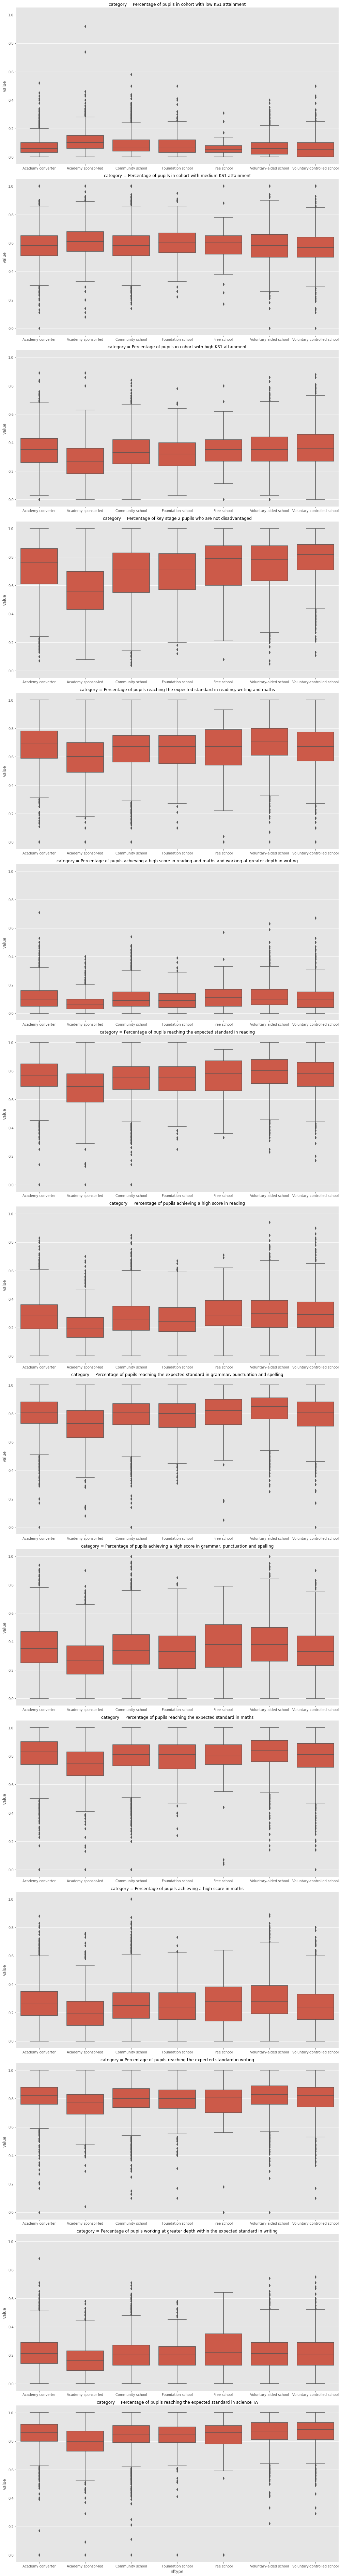

In [111]:
type_order = np.sort(df_long.nftype.unique()).tolist() # Unique school types (7 in total) sorted alphabetically
g = sns.FacetGrid(df_long, col='category', col_wrap=1, margin_titles=True, legend_out=True, height=7, aspect=2, sharex=False)
g.map(sns.boxplot, 'nftype', 'value', order=type_order)

Interesting... The plots above strongly indicate that sponsor-led academies tend to have lower performance and higher percentage of disadvantaged pupils. However, is there a chance that these results are not statistically significant and are just a fluke? It is possible, but the fact that we have observed consistently lower performance indicated by several features makes it less likely. Nevertheless, it is still worth it to perform some statistical tests. 

The test we are going to do is the Kruskal-Wallis H-test, which is a non-parametric version of ANOVA (analysis of variance). The null hypothesis is that the population median of all of the groups are equal, and comparing to the 'traditional' ANOVA this test is more flexible. Specifically, it allows for different sizes of the groups, which is exactly the case. It is important to clarify, however, that rejecting the null hypothesis does not indicate which of the groups differs.

Let's start with a simple example. For PTNotFSM6CLA1A (percentage of key stage 2 pupils who are not disadvantaged), we have seen in a plot above that the medians of, for example, for community and foundation schools are identical (both at 0.71 in our samples), but it is very different for sponsor-led academies (only 0.56). The test works for two or more groups, but let's do it for two pairs first, as a 'sanity check'. The two pairs will be: foundation schools vs community schools, and then foundation schools vs sponsor-led academies. In the first case, we expect a failure to reject the null hypothesis (that the medians are equal), and in the second one we expect a strong rejection. 

In [112]:
x = df['PTNotFSM6CLA1A'][df['NFTYPE'] == 'Foundation school']
y = df['PTNotFSM6CLA1A'][df['NFTYPE'] == 'Community school']
stats.kruskal(x, y)

KruskalResult(statistic=0.02124901571534445, pvalue=0.8841026268553486)

Indeed, the high p-value indicates that we fail to reject the null hypothesis. 

In [113]:
x = df['PTNotFSM6CLA1A'][df['NFTYPE'] == 'Foundation school']
y = df['PTNotFSM6CLA1A'][df['NFTYPE'] == 'Academy sponsor-led']
stats.kruskal(x, y)

KruskalResult(statistic=141.82853416219706, pvalue=1.0601649707893037e-32)

In line with our expectation, the null hypothesis can be safely rejected even at an extremely low confidence level. 

In the context of this discussion, it is worth reminding what the p-value actually means, since it is often misunderstood and misused. Technically, it is the probability of obtaining test results at least as extreme as the results actually observed, if the null hypothesis is true. In other words, if the true *population* medians are actually equal, p-value is the probability of obtaining *sample* medians at least as extreme as the ones we have actually observed in our samples. 

But there is no need, of course, to limit ourselves only to one feature and two pairs of categories. We can do this for all of them in one go (remember that the Kruskal-Wallis test can be run for two or more arrays, which can be of different lengths). Let's make a function for it, to make it easier to do. 

In [114]:
cols # Features to test

['PTKS1GROUP_L',
 'PTKS1GROUP_M',
 'PTKS1GROUP_H',
 'PTNotFSM6CLA1A',
 'PTRWM_EXP',
 'PTRWM_HIGH',
 'PTREAD_EXP',
 'PTREAD_HIGH',
 'PTGPS_EXP',
 'PTGPS_HIGH',
 'PTMAT_EXP',
 'PTMAT_HIGH',
 'PTWRITTA_EXP',
 'PTWRITTA_HIGH',
 'PTSCITA_EXP']

In [115]:
type_order # School types in alphabetical order

['Academy converter',
 'Academy sponsor-led',
 'Community school',
 'Foundation school',
 'Free school',
 'Voluntary-aided school',
 'Voluntary-controlled school']

In [116]:
def run_kw_tests(sch_types, feature):
    """
    Runs the Kruskal-Wallis test taking each sample in samples_list as a separate input.
    """
    samples_list = []
    for sch_type in sch_types:
        samples_list.append(df[feature][df['NFTYPE'] == sch_type].copy())
    print('-------------------------------')
    print('Running the Kruskal-Wallis test for ' + str(feature))
    print(category_dict[feature])
    print(stats.kruskal(*samples_list, nan_policy='omit'))

In [117]:
for feature in cols:
    run_kw_tests(type_order, feature)

-------------------------------
Running the Kruskal-Wallis test for PTKS1GROUP_L
Percentage of pupils in cohort with low KS1 attainment
KruskalResult(statistic=541.8978337364105, pvalue=7.876459965967087e-114)
-------------------------------
Running the Kruskal-Wallis test for PTKS1GROUP_M
Percentage of pupils in cohort with medium KS1 attainment
KruskalResult(statistic=123.81300033144036, pvalue=2.5752498411059857e-24)
-------------------------------
Running the Kruskal-Wallis test for PTKS1GROUP_H
Percentage of pupils in cohort with high KS1 attainment
KruskalResult(statistic=409.99495451481437, pvalue=1.9834938819719506e-85)
-------------------------------
Running the Kruskal-Wallis test for PTNotFSM6CLA1A
Percentage of key stage 2 pupils who are not disadvantaged
KruskalResult(statistic=1141.6126049111044, pvalue=2.0674823764908963e-243)
-------------------------------
Running the Kruskal-Wallis test for PTRWM_EXP
Percentage of pupils reaching the expected standard in reading, writ

D:\anaconda3\lib\site-packages\numpy\ma\core.py:4036: RuntimeWarning: invalid value encountered in equal
  check = compare(sdata, odata)



-------------------------------
Running the Kruskal-Wallis test for PTMAT_HIGH
Percentage of pupils achieving a high score in maths
KruskalResult(statistic=346.85970075470334, pvalue=7.28784082112736e-72)
-------------------------------
Running the Kruskal-Wallis test for PTWRITTA_EXP
Percentage of pupils reaching the expected standard in writing
KruskalResult(statistic=346.33554106641753, pvalue=9.44305936945721e-72)
-------------------------------
Running the Kruskal-Wallis test for PTWRITTA_HIGH
Percentage of pupils working at greater depth within the expected standard in writing
KruskalResult(statistic=209.62640599727794, pvalue=1.6915810837384693e-42)
-------------------------------
Running the Kruskal-Wallis test for PTSCITA_EXP
Percentage of pupils reaching the expected standard in science TA
KruskalResult(statistic=471.1580915589848, pvalue=1.368518526828055e-98)



Unsurprisingly, we have found that there *are* statistically significant differences between the medians. In other words, the groups by school types *do* come from different populations. 

However, the test does not tell us which group (or groups) exactly are different from the rest. While we suspect academy sponsor-led, this is not certain. 

Let's try to do the same test, but without the most different type, academy sponsor led, and see how different are the rest of them, between themselves. 

In [118]:
type_order.remove('Academy sponsor-led') # Note that removal was done in-place
type_order

['Academy converter',
 'Community school',
 'Foundation school',
 'Free school',
 'Voluntary-aided school',
 'Voluntary-controlled school']

In [119]:
type_order

['Academy converter',
 'Community school',
 'Foundation school',
 'Free school',
 'Voluntary-aided school',
 'Voluntary-controlled school']

In [120]:
for feature in cols:
    run_kw_tests(type_order, feature)

-------------------------------
Running the Kruskal-Wallis test for PTKS1GROUP_L
Percentage of pupils in cohort with low KS1 attainment
KruskalResult(statistic=239.05718546461932, pvalue=1.2229307233314895e-49)
-------------------------------
Running the Kruskal-Wallis test for PTKS1GROUP_M
Percentage of pupils in cohort with medium KS1 attainment
KruskalResult(statistic=26.266559350179097, pvalue=7.92163218496064e-05)
-------------------------------
Running the Kruskal-Wallis test for PTKS1GROUP_H
Percentage of pupils in cohort with high KS1 attainment
KruskalResult(statistic=88.12956751953315, pvalue=1.6599955308525515e-17)
-------------------------------
Running the Kruskal-Wallis test for PTNotFSM6CLA1A
Percentage of key stage 2 pupils who are not disadvantaged
KruskalResult(statistic=512.671489522383, pvalue=1.4686454529493462e-108)
-------------------------------
Running the Kruskal-Wallis test for PTRWM_EXP
Percentage of pupils reaching the expected standard in reading, writing 


This is slightly unexpected. The results above suggest that even without the school type which is most unlike the others, the differences in their performance results are still statistically significant. 